# Data-Driven Discovery of a Discrete-Time Recurrence

## Data Preparation

In [3]:
# Cell 1: Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Username for plots
USERNAME = "atharv.bhatt"

def add_username_to_plot():
    """Add username watermark to current plot"""
    plt.text(0.95, 0.95, USERNAME,
             ha='right', va='top',
             transform=plt.gca().transAxes,
             fontsize=10, color='gray', alpha=0.7)

Using device: cuda


Dataset shape: (54000, 1)

First few rows:
    x_value
0  0.364704
1 -0.892358
2 -0.559280
3 -0.631256
4 -0.648188
5  0.624189
6  0.846690
7 -0.446851
8 -0.298837
9 -0.112003

Basic statistics:
            x_value
count  54000.000000
mean      -0.000680
std        0.161285
min       -0.999627
25%       -0.000136
50%        0.000000
75%        0.000117
max        0.999707

Time series length: 54000


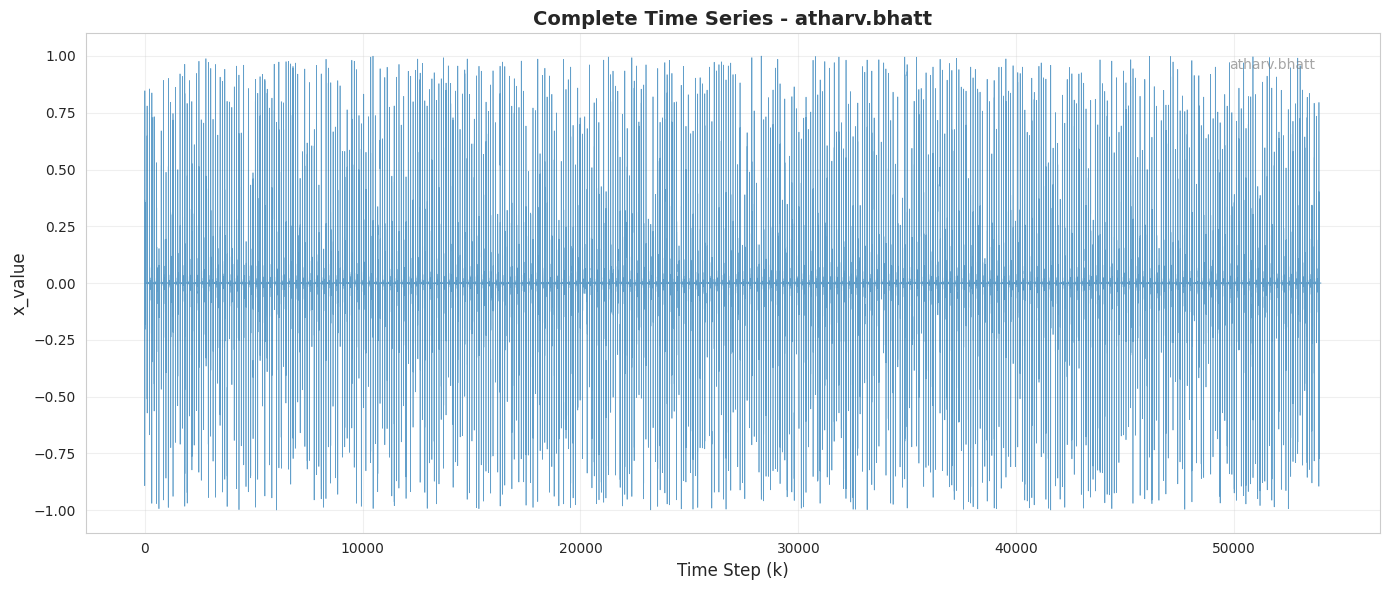

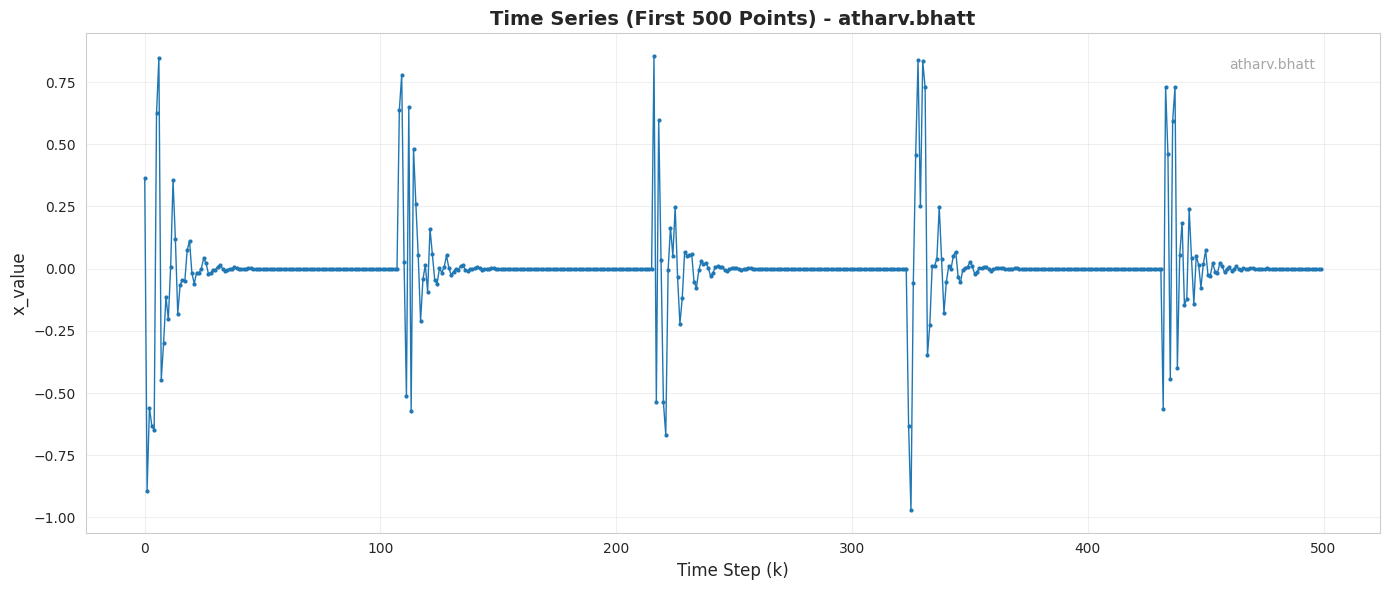

In [4]:
# Cell 2: Load and Explore Data
# Load the data
data_path = 'recurrence_timeseries.csv'
df = pd.read_csv(data_path)
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:\n{df.head(10)}")
print(f"\nBasic statistics:\n{df.describe()}")

# Extract the time series
time_series = df['x_value'].values
print(f"\nTime series length: {len(time_series)}")

# Plot the full time series
plt.figure(figsize=(14, 6))
plt.plot(time_series, linewidth=0.5, alpha=0.7)
plt.title(f'Complete Time Series - {USERNAME}', fontsize=14, fontweight='bold')
plt.xlabel('Time Step (k)', fontsize=12)
plt.ylabel('x_value', fontsize=12)
plt.grid(True, alpha=0.3)
add_username_to_plot()
plt.tight_layout()
plt.show()

# Plot a zoomed-in section to see patterns
plt.figure(figsize=(14, 6))
plt.plot(time_series[:500], linewidth=1, marker='o', markersize=2)
plt.title(f'Time Series (First 500 Points) - {USERNAME}', fontsize=14, fontweight='bold')
plt.xlabel('Time Step (k)', fontsize=12)
plt.ylabel('x_value', fontsize=12)
plt.grid(True, alpha=0.3)
add_username_to_plot()
plt.tight_layout()
plt.show()

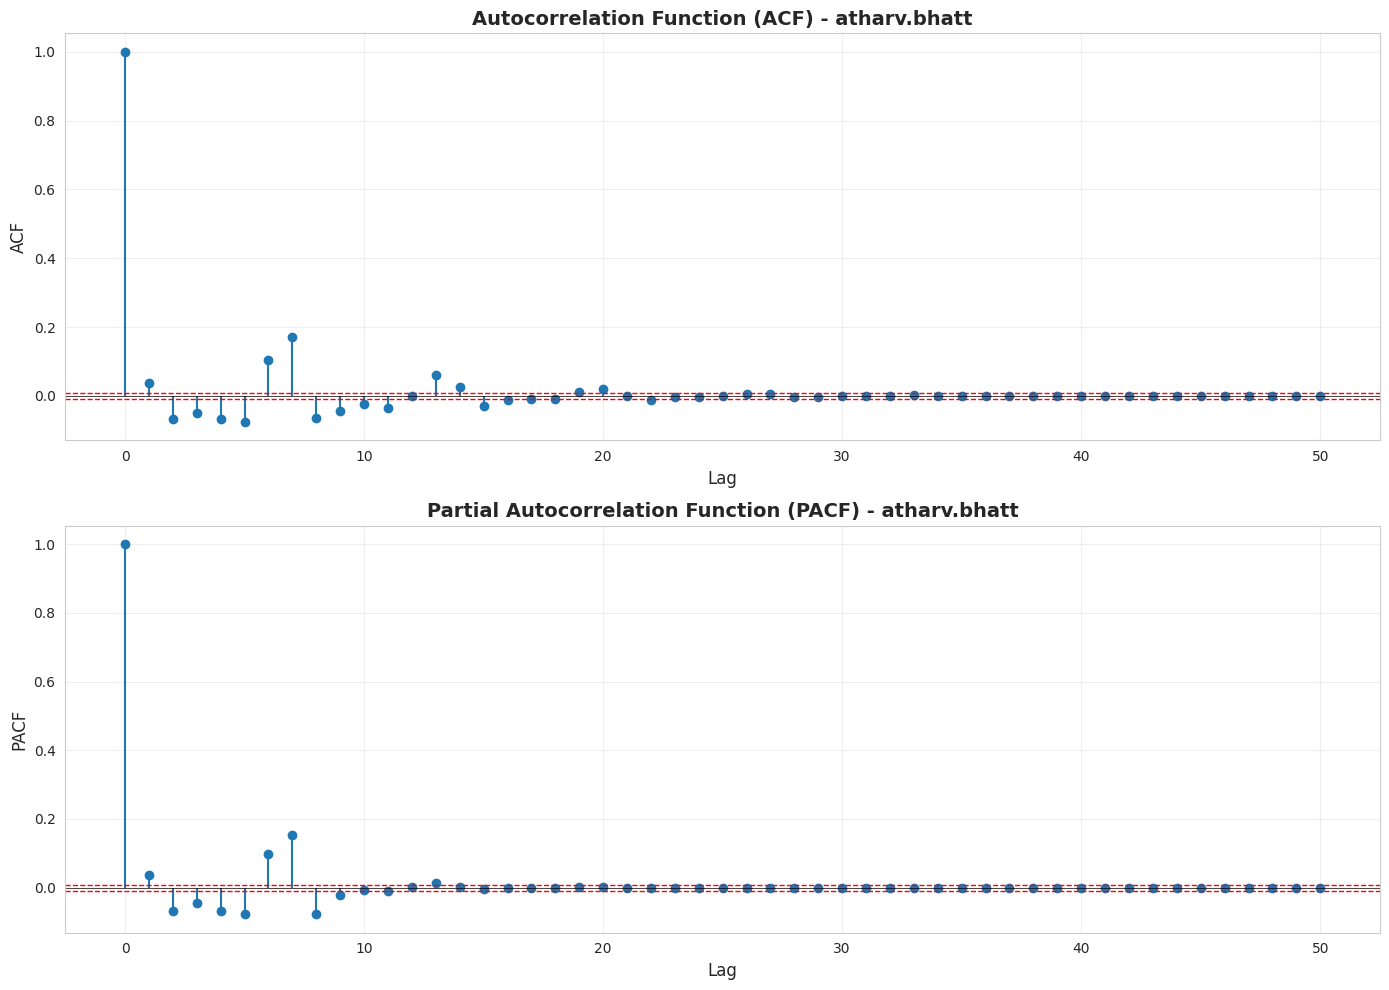


Significant lags in PACF: [ 1  2  3  4  5  6  7  8  9 11]
Suggested minimum history length (p): 1


In [5]:
# Cell 3: Autocorrelation Analysis to Determine History Length
# Compute ACF and PACF
lags = 50
acf_values = acf(time_series, nlags=lags)
pacf_values = pacf(time_series, nlags=lags)

# Plot ACF
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# ACF plot
axes[0].stem(range(len(acf_values)), acf_values, basefmt=' ')
axes[0].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[0].axhline(y=1.96/np.sqrt(len(time_series)), color='r', linestyle='--', linewidth=1)
axes[0].axhline(y=-1.96/np.sqrt(len(time_series)), color='r', linestyle='--', linewidth=1)
axes[0].set_title(f'Autocorrelation Function (ACF) - {USERNAME}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Lag', fontsize=12)
axes[0].set_ylabel('ACF', fontsize=12)
axes[0].grid(True, alpha=0.3)

# PACF plot
axes[1].stem(range(len(pacf_values)), pacf_values, basefmt=' ')
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[1].axhline(y=1.96/np.sqrt(len(time_series)), color='r', linestyle='--', linewidth=1)
axes[1].axhline(y=-1.96/np.sqrt(len(time_series)), color='r', linestyle='--', linewidth=1)
axes[1].set_title(f'Partial Autocorrelation Function (PACF) - {USERNAME}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lag', fontsize=12)
axes[1].set_ylabel('PACF', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify significant lags in PACF
threshold = 1.96/np.sqrt(len(time_series))
significant_lags = np.where(np.abs(pacf_values[1:]) > threshold)[0] + 1
print(f"\nSignificant lags in PACF: {significant_lags[:10]}")
print(f"Suggested minimum history length (p): {min(significant_lags[:5]) if len(significant_lags) > 0 else 3}")

Total data points: 54000

Train set: 37800 points (70.0%)
Validation set: 8100 points (15.0%)
Test set: 8100 points (15.0%)

Justification:
- Chronological split preserves temporal structure (no data leakage)
- 70-15-15 split provides sufficient training data while maintaining
  substantial validation and test sets for robust evaluation
- ~37,800 training points allow learning complex patterns
- ~8,100 validation/test points enable reliable performance assessment


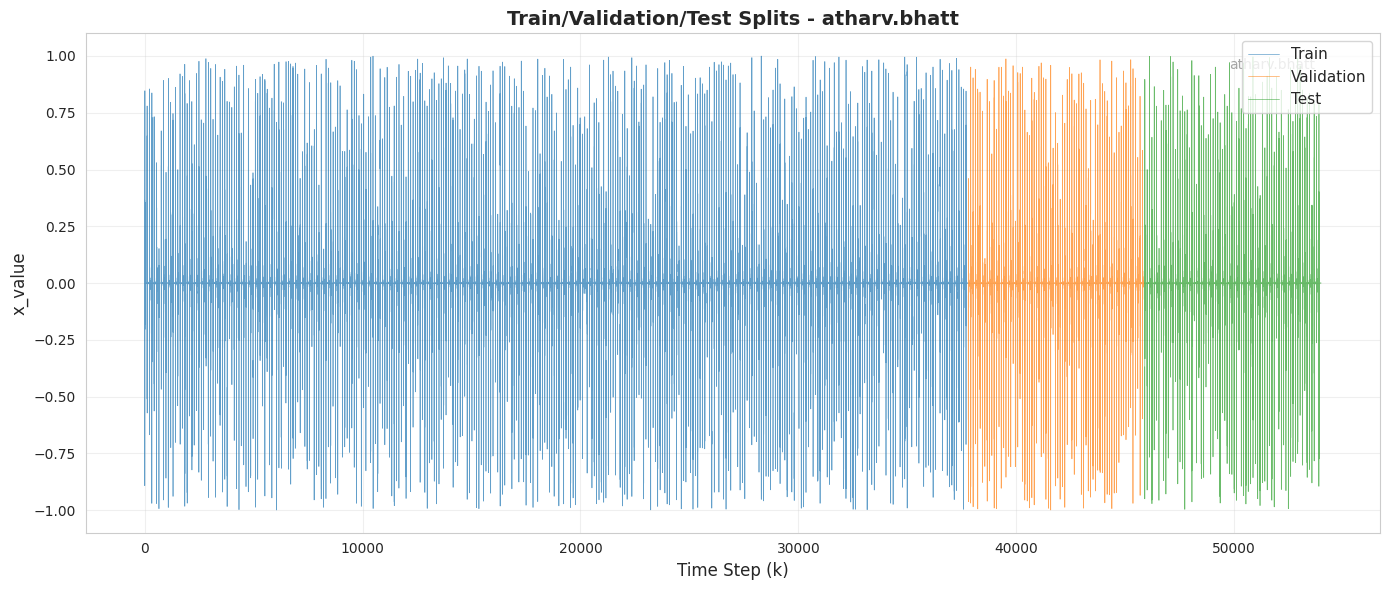

In [6]:
# Cell 4: Train/Validation/Test Splits
# Define split ratios
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

n = len(time_series)
train_size = int(n * train_ratio)
val_size = int(n * val_ratio)
test_size = n - train_size - val_size

# Create splits (chronological)
train_data = time_series[:train_size]
val_data = time_series[train_size:train_size + val_size]
test_data = time_series[train_size + val_size:]

print(f"Total data points: {n}")
print(f"\nTrain set: {len(train_data)} points ({train_ratio*100:.1f}%)")
print(f"Validation set: {len(val_data)} points ({val_ratio*100:.1f}%)")
print(f"Test set: {len(test_data)} points ({test_ratio*100:.1f}%)")
print(f"\nJustification:")
print("- Chronological split preserves temporal structure (no data leakage)")
print("- 70-15-15 split provides sufficient training data while maintaining")
print("  substantial validation and test sets for robust evaluation")
print("- ~37,800 training points allow learning complex patterns")
print("- ~8,100 validation/test points enable reliable performance assessment")

# Visualize splits
plt.figure(figsize=(14, 6))
plt.plot(range(len(train_data)), train_data, label='Train', alpha=0.7, linewidth=0.5)
plt.plot(range(len(train_data), len(train_data) + len(val_data)), val_data,
         label='Validation', alpha=0.7, linewidth=0.5)
plt.plot(range(len(train_data) + len(val_data), n), test_data,
         label='Test', alpha=0.7, linewidth=0.5)
plt.title(f'Train/Validation/Test Splits - {USERNAME}', fontsize=14, fontweight='bold')
plt.xlabel('Time Step (k)', fontsize=12)
plt.ylabel('x_value', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
add_username_to_plot()
plt.tight_layout()
plt.show()

Training set statistics:
  Mean: -0.000683
  Std:  0.161410

Normalized training set statistics:
  Mean: 0.000000
  Std:  1.000000

Normalization formula:
  x_norm = (x - -0.000683) / 0.161410

Inverse transformation:
  x = x_norm * 0.161410 + -0.000683


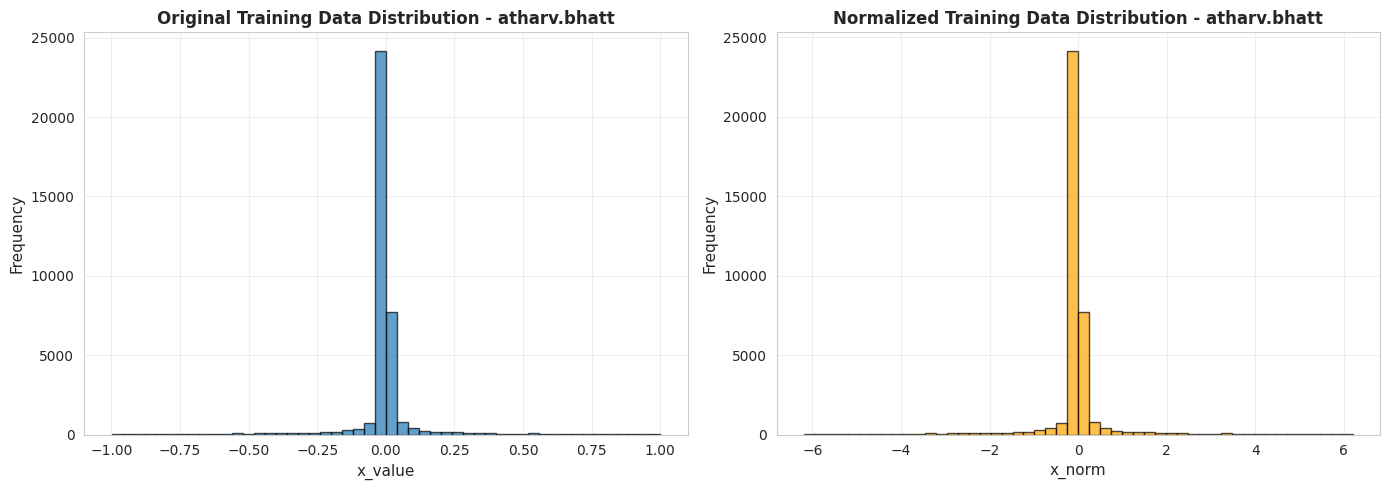

In [7]:
# Cell 5: Normalization
# Compute statistics from training set only
train_mean = np.mean(train_data)
train_std = np.std(train_data)

print(f"Training set statistics:")
print(f"  Mean: {train_mean:.6f}")
print(f"  Std:  {train_std:.6f}")

# Normalization function
def normalize(data, mean, std):
    """Apply z-score normalization"""
    return (data - mean) / std

# Inverse normalization function
def denormalize(data_norm, mean, std):
    """Inverse z-score normalization"""
    return data_norm * std + mean

# Apply normalization
train_data_norm = normalize(train_data, train_mean, train_std)
val_data_norm = normalize(val_data, train_mean, train_std)
test_data_norm = normalize(test_data, train_mean, train_std)

print(f"\nNormalized training set statistics:")
print(f"  Mean: {np.mean(train_data_norm):.6f}")
print(f"  Std:  {np.std(train_data_norm):.6f}")

print(f"\nNormalization formula:")
print(f"  x_norm = (x - {train_mean:.6f}) / {train_std:.6f}")
print(f"\nInverse transformation:")
print(f"  x = x_norm * {train_std:.6f} + {train_mean:.6f}")

# Visualize normalization effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(train_data, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title(f'Original Training Data Distribution - {USERNAME}', fontsize=12, fontweight='bold')
axes[0].set_xlabel('x_value', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].hist(train_data_norm, bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_title(f'Normalized Training Data Distribution - {USERNAME}', fontsize=12, fontweight='bold')
axes[1].set_xlabel('x_norm', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Cell 6: Create Supervised Dataset
def create_supervised_dataset(data, history_length):
    """
    Create supervised learning dataset from time series

    Args:
        data: 1D array of time series values
        history_length: number of previous time steps to use (p)

    Returns:
        X: array of shape (n_samples, history_length) - input sequences
        y: array of shape (n_samples,) - target values
    """
    X, y = [], []

    for i in range(history_length, len(data)):
        # History: [x_{k-p}, x_{k-p+1}, ..., x_{k-1}]
        X.append(data[i-history_length:i])
        # Target: x_k
        y.append(data[i])

    return np.array(X), np.array(y)

# Test with different history lengths
test_p_values = [1, 2, 3, 5, 10]

print("Supervised dataset creation:")
print(f"Format: X[i] = [x_{{k-p}}, ..., x_{{k-1}}], y[i] = x_k\n")

for p in test_p_values:
    X_test, y_test = create_supervised_dataset(train_data_norm[:100], p)
    print(f"History length p={p}:")
    print(f"  Input shape: {X_test.shape}")
    print(f"  Target shape: {y_test.shape}")
    print(f"  Example: X[0] = {X_test[0][:3]}... -> y[0] = {y_test[0]:.4f}\n")

Supervised dataset creation:
Format: X[i] = [x_{k-p}, ..., x_{k-1}], y[i] = x_k

History length p=1:
  Input shape: (99, 1)
  Target shape: (99,)
  Example: X[0] = [2.26371859]... -> y[0] = -5.5243

History length p=2:
  Input shape: (98, 2)
  Target shape: (98,)
  Example: X[0] = [ 2.26371859 -5.52429027]... -> y[0] = -3.4607

History length p=3:
  Input shape: (97, 3)
  Target shape: (97,)
  Example: X[0] = [ 2.26371859 -5.52429027 -3.46073699]... -> y[0] = -3.9067

History length p=5:
  Input shape: (95, 5)
  Target shape: (95,)
  Example: X[0] = [ 2.26371859 -5.52429027 -3.46073699]... -> y[0] = 3.8713

History length p=10:
  Input shape: (90, 10)
  Target shape: (90,)
  Example: X[0] = [ 2.26371859 -5.52429027 -3.46073699]... -> y[0] = -1.2599



History length (p) selection strategy:
1. Use ACF/PACF analysis to identify significant lags
2. Test multiple values on validation set
3. Balance model complexity vs. performance
4. Start with p ∈ {1, 2, 3, 5, 10} based on PACF analysis

## Model Architecture

In [9]:
# Cell 7: Define Model Architectures

class LinearAR(nn.Module):
    """Linear Autoregressive Model: x_k = θ₁·x_{k-1} + ... + θₚ·x_{k-p} + θ₀"""
    def __init__(self, history_length):
        super(LinearAR, self).__init__()
        self.linear = nn.Linear(history_length, 1)

    def forward(self, x):
        # x shape: (batch_size, history_length)
        return self.linear(x).squeeze(-1)

    def get_coefficients(self):
        """Extract analytical coefficients"""
        weights = self.linear.weight.data.cpu().numpy().flatten()
        bias = self.linear.bias.data.cpu().numpy()[0]
        return weights, bias


class MLPPredictor(nn.Module):
    """Multi-Layer Perceptron for sequence prediction"""
    def __init__(self, history_length, hidden_sizes=[64, 32]):
        super(MLPPredictor, self).__init__()
        layers = []
        input_size = history_length

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))
            input_size = hidden_size

        layers.append(nn.Linear(input_size, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        # x shape: (batch_size, history_length)
        return self.network(x).squeeze(-1)


class GRUPredictor(nn.Module):
    """GRU-based sequence predictor"""
    def __init__(self, history_length, hidden_size=8, num_layers=1):
        super(GRUPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # GRU expects input of shape (batch, seq_len, input_size)
        self.gru = nn.GRU(input_size=1,
                         hidden_size=hidden_size,
                         num_layers=num_layers,
                         batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch_size, history_length)
        # Reshape to (batch_size, history_length, 1)
        x = x.unsqueeze(-1)

        # GRU forward
        gru_out, _ = self.gru(x)

        # Take the last output
        last_output = gru_out[:, -1, :]

        # Fully connected layer
        output = self.fc(last_output).squeeze(-1)
        return output


def count_parameters(model):
    """Count trainable parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Test model instantiation
print("Model Architectures Summary:\n")
print("="*70)

for p in [3, 5]:
    print(f"\nHistory length p={p}:")
    print("-"*70)

    linear_ar = LinearAR(p)
    print(f"1. Linear AR: {count_parameters(linear_ar)} parameters")
    print(f"   Formula: x_k = θ₁·x_{{k-1}} + ... + θ_{p}·x_{{k-{p}}} + θ₀")

    mlp = MLPPredictor(p, hidden_sizes=[32, 16])
    print(f"2. MLP [32, 16]: {count_parameters(mlp)} parameters")

    gru = GRUPredictor(p, hidden_size=4, num_layers=1)
    print(f"3. GRU (h=4, layers=1): {count_parameters(gru)} parameters")

print("\n" + "="*70)

Model Architectures Summary:


History length p=3:
----------------------------------------------------------------------
1. Linear AR: 4 parameters
   Formula: x_k = θ₁·x_{k-1} + ... + θ_3·x_{k-3} + θ₀
2. MLP [32, 16]: 673 parameters
3. GRU (h=4, layers=1): 89 parameters

History length p=5:
----------------------------------------------------------------------
1. Linear AR: 6 parameters
   Formula: x_k = θ₁·x_{k-1} + ... + θ_5·x_{k-5} + θ₀
2. MLP [32, 16]: 737 parameters
3. GRU (h=4, layers=1): 89 parameters



In [10]:
# Cell 8: Training Function

def train_model(model, train_loader, val_loader, num_epochs=200,
                learning_rate=0.001, patience=20, model_name="Model"):
    """
    Train a model with early stopping

    Args:
        model: PyTorch model
        train_loader: DataLoader for training data
        val_loader: DataLoader for validation data
        num_epochs: Maximum number of epochs
        learning_rate: Learning rate for optimizer
        patience: Early stopping patience
        model_name: Name for logging

    Returns:
        model: Trained model
        history: Dictionary with training history
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_mae': [],
        'val_mae': []
    }

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []
        train_maes = []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_maes.append(torch.mean(torch.abs(predictions - y_batch)).item())

        # Validation phase
        model.eval()
        val_losses = []
        val_maes = []

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)

                val_losses.append(loss.item())
                val_maes.append(torch.mean(torch.abs(predictions - y_batch)).item())

        # Record history
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        train_mae = np.mean(train_maes)
        val_mae = np.mean(val_maes)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mae'].append(train_mae)
        history['val_mae'].append(val_mae)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        # Print progress
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, "
                  f"Val MAE: {val_mae:.6f}")

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(f"\n{model_name} training complete!")
    print(f"Best validation loss: {best_val_loss:.6f}")

    return model, history


def evaluate_model(model, data_loader, denorm_mean, denorm_std):
    """Evaluate model and return predictions and metrics"""
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    # Denormalize
    predictions_denorm = denormalize(all_predictions, denorm_mean, denorm_std)
    targets_denorm = denormalize(all_targets, denorm_mean, denorm_std)

    # Compute metrics
    mae = mean_absolute_error(targets_denorm, predictions_denorm)
    mse = mean_squared_error(targets_denorm, predictions_denorm)
    rmse = np.sqrt(mse)

    return predictions_denorm, targets_denorm, mae, mse, rmse

print("Training function defined successfully!")

Training function defined successfully!


In [11]:
# Cell 9: Hyperparameter Search

# Define hyperparameter grid
history_lengths = [1, 2, 3, 5, 10]
model_configs = {
    'LinearAR': [],
    'MLP': [[32, 16], [64, 32], [32]],
    'GRU': [(2, 1), (4, 1), (8, 1), (4, 2)]  # (hidden_size, num_layers)
}

# Store results
results = []

print("Starting Hyperparameter Search...")
print("="*80)

for p in history_lengths:
    print(f"\n{'='*80}")
    print(f"Testing History Length p={p}")
    print(f"{'='*80}\n")

    # Create datasets
    X_train, y_train = create_supervised_dataset(train_data_norm, p)
    X_val, y_val = create_supervised_dataset(val_data_norm, p)

    # Convert to tensors
    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.FloatTensor(y_train)
    X_val_t = torch.FloatTensor(X_val)
    y_val_t = torch.FloatTensor(y_val)

    # Create data loaders
    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Test Linear AR
    print(f"\n{'-'*80}")
    print(f"Training Linear AR (p={p})")
    print(f"{'-'*80}")
    model = LinearAR(p).to(device)
    model, history = train_model(model, train_loader, val_loader,
                                 num_epochs=200, learning_rate=0.001,
                                 model_name=f"LinearAR_p{p}")

    _, _, val_mae, val_mse, _ = evaluate_model(model, val_loader, train_mean, train_std)

    results.append({
        'model_type': 'LinearAR',
        'history_length': p,
        'config': 'None',
        'parameters': count_parameters(model),
        'val_mae': val_mae,
        'val_mse': val_mse,
        'trained_model': model
    })

    print(f"Validation MAE: {val_mae:.6f}, MSE: {val_mse:.6f}")

    # Test MLP
    for hidden_sizes in model_configs['MLP']:
        print(f"\n{'-'*80}")
        print(f"Training MLP {hidden_sizes} (p={p})")
        print(f"{'-'*80}")
        model = MLPPredictor(p, hidden_sizes=hidden_sizes).to(device)
        model, history = train_model(model, train_loader, val_loader,
                                     num_epochs=200, learning_rate=0.001,
                                     model_name=f"MLP{hidden_sizes}_p{p}")

        _, _, val_mae, val_mse, _ = evaluate_model(model, val_loader, train_mean, train_std)

        results.append({
            'model_type': 'MLP',
            'history_length': p,
            'config': str(hidden_sizes),
            'parameters': count_parameters(model),
            'val_mae': val_mae,
            'val_mse': val_mse,
            'trained_model': model
        })

        print(f"Validation MAE: {val_mae:.6f}, MSE: {val_mse:.6f}")

    # Test GRU
    for hidden_size, num_layers in model_configs['GRU']:
        print(f"\n{'-'*80}")
        print(f"Training GRU (h={hidden_size}, layers={num_layers}, p={p})")
        print(f"{'-'*80}")
        model = GRUPredictor(p, hidden_size=hidden_size, num_layers=num_layers).to(device)
        model, history = train_model(model, train_loader, val_loader,
                                     num_epochs=200, learning_rate=0.001,
                                     model_name=f"GRU_h{hidden_size}_l{num_layers}_p{p}")

        _, _, val_mae, val_mse, _ = evaluate_model(model, val_loader, train_mean, train_std)

        results.append({
            'model_type': 'GRU',
            'history_length': p,
            'config': f"h={hidden_size},l={num_layers}",
            'parameters': count_parameters(model),
            'val_mae': val_mae,
            'val_mse': val_mse,
            'trained_model': model
        })

        print(f"Validation MAE: {val_mae:.6f}, MSE: {val_mse:.6f}")

print(f"\n{'='*80}")
print("Hyperparameter Search Complete!")
print(f"{'='*80}\n")

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('val_mae')

print("\nTop 10 Models by Validation MAE:")
print(results_df[['model_type', 'history_length', 'config', 'parameters', 'val_mae', 'val_mse']].head(10).to_string(index=False))

Starting Hyperparameter Search...

Testing History Length p=1


--------------------------------------------------------------------------------
Training Linear AR (p=1)
--------------------------------------------------------------------------------
Epoch [1/200] - Train Loss: 1.939497, Val Loss: 1.786963, Val MAE: 0.889590
Epoch [20/200] - Train Loss: 0.998614, Val Loss: 1.013211, Val MAE: 0.308335
Epoch [40/200] - Train Loss: 0.997994, Val Loss: 1.013292, Val MAE: 0.306577
Early stopping at epoch 56

LinearAR_p1 training complete!
Best validation loss: 1.013163
Validation MAE: 0.050506, MSE: 0.026571

--------------------------------------------------------------------------------
Training MLP [32, 16] (p=1)
--------------------------------------------------------------------------------
Epoch [1/200] - Train Loss: 1.002138, Val Loss: 1.011461, Val MAE: 0.316401
Epoch [20/200] - Train Loss: 0.996701, Val Loss: 1.009072, Val MAE: 0.308879
Epoch [40/200] - Train Loss: 0.996908, Val Lo

In [12]:
# Cell 10: Train Best Models and Visualize

# Select best models from each type
best_linear = results_df[results_df['model_type'] == 'LinearAR'].iloc[0]
best_mlp = results_df[results_df['model_type'] == 'MLP'].iloc[0]
best_gru = results_df[results_df['model_type'] == 'GRU'].iloc[0]
overall_best = results_df.iloc[0]

print("Best Models Summary:")
print("="*80)
print(f"\nBest Linear AR:")
print(f"  p={best_linear['history_length']}, Val MAE={best_linear['val_mae']:.6f}")

print(f"\nBest MLP:")
print(f"  p={best_mlp['history_length']}, config={best_mlp['config']}, Val MAE={best_mlp['val_mae']:.6f}")

print(f"\nBest GRU:")
print(f"  p={best_gru['history_length']}, config={best_gru['config']}, Val MAE={best_gru['val_mae']:.6f}")

print(f"\nOverall Best Model:")
print(f"  Type={overall_best['model_type']}, p={overall_best['history_length']}, Val MAE={overall_best['val_mae']:.6f}")

# Retrain best models with history tracking for visualization
best_models = {}
best_histories = {}

for name, best_result in [('LinearAR', best_linear), ('MLP', best_mlp), ('GRU', best_gru)]:
    p = best_result['history_length']

    print(f"\n{'-'*80}")
    print(f"Retraining best {name} model (p={p}) with full history tracking...")
    print(f"{'-'*80}")

    # Recreate datasets
    X_train, y_train = create_supervised_dataset(train_data_norm, p)
    X_val, y_val = create_supervised_dataset(val_data_norm, p)

    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.FloatTensor(y_train)
    X_val_t = torch.FloatTensor(X_val)
    y_val_t = torch.FloatTensor(y_val)

    train_dataset = TensorDataset(X_train_t, y_train_t)
    val_dataset = TensorDataset(X_val_t, y_val_t)

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # Recreate model
    if name == 'LinearAR':
        model = LinearAR(p).to(device)
    elif name == 'MLP':
        hidden_sizes = eval(best_result['config'])
        model = MLPPredictor(p, hidden_sizes=hidden_sizes).to(device)
    else:  # GRU
        config = best_result['config']
        h = int(config.split('h=')[1].split(',')[0])
        l = int(config.split('l=')[1])
        model = GRUPredictor(p, hidden_size=h, num_layers=l).to(device)

    # Train
    model, history = train_model(model, train_loader, val_loader,
                                 num_epochs=300, learning_rate=0.001,
                                 patience=30, model_name=f"Best_{name}")

    best_models[name] = (model, p)
    best_histories[name] = history

print("\n" + "="*80)
print("Best models retrained successfully!")
print("="*80)

Best Models Summary:

Best Linear AR:
  p=10, Val MAE=0.040264

Best MLP:
  p=10, config=[32, 16], Val MAE=0.039348

Best GRU:
  p=10, config=h=8,l=1, Val MAE=0.040063

Overall Best Model:
  Type=MLP, p=10, Val MAE=0.039348

--------------------------------------------------------------------------------
Retraining best LinearAR model (p=10) with full history tracking...
--------------------------------------------------------------------------------
Epoch [1/300] - Train Loss: 1.094947, Val Loss: 1.026365, Val MAE: 0.300836
Epoch [20/300] - Train Loss: 0.937340, Val Loss: 0.956799, Val MAE: 0.246335
Epoch [40/300] - Train Loss: 0.937339, Val Loss: 0.956891, Val MAE: 0.246513
Early stopping at epoch 49

Best_LinearAR training complete!
Best validation loss: 0.956685

--------------------------------------------------------------------------------
Retraining best MLP model (p=10) with full history tracking...
------------------------------------------------------------------------------

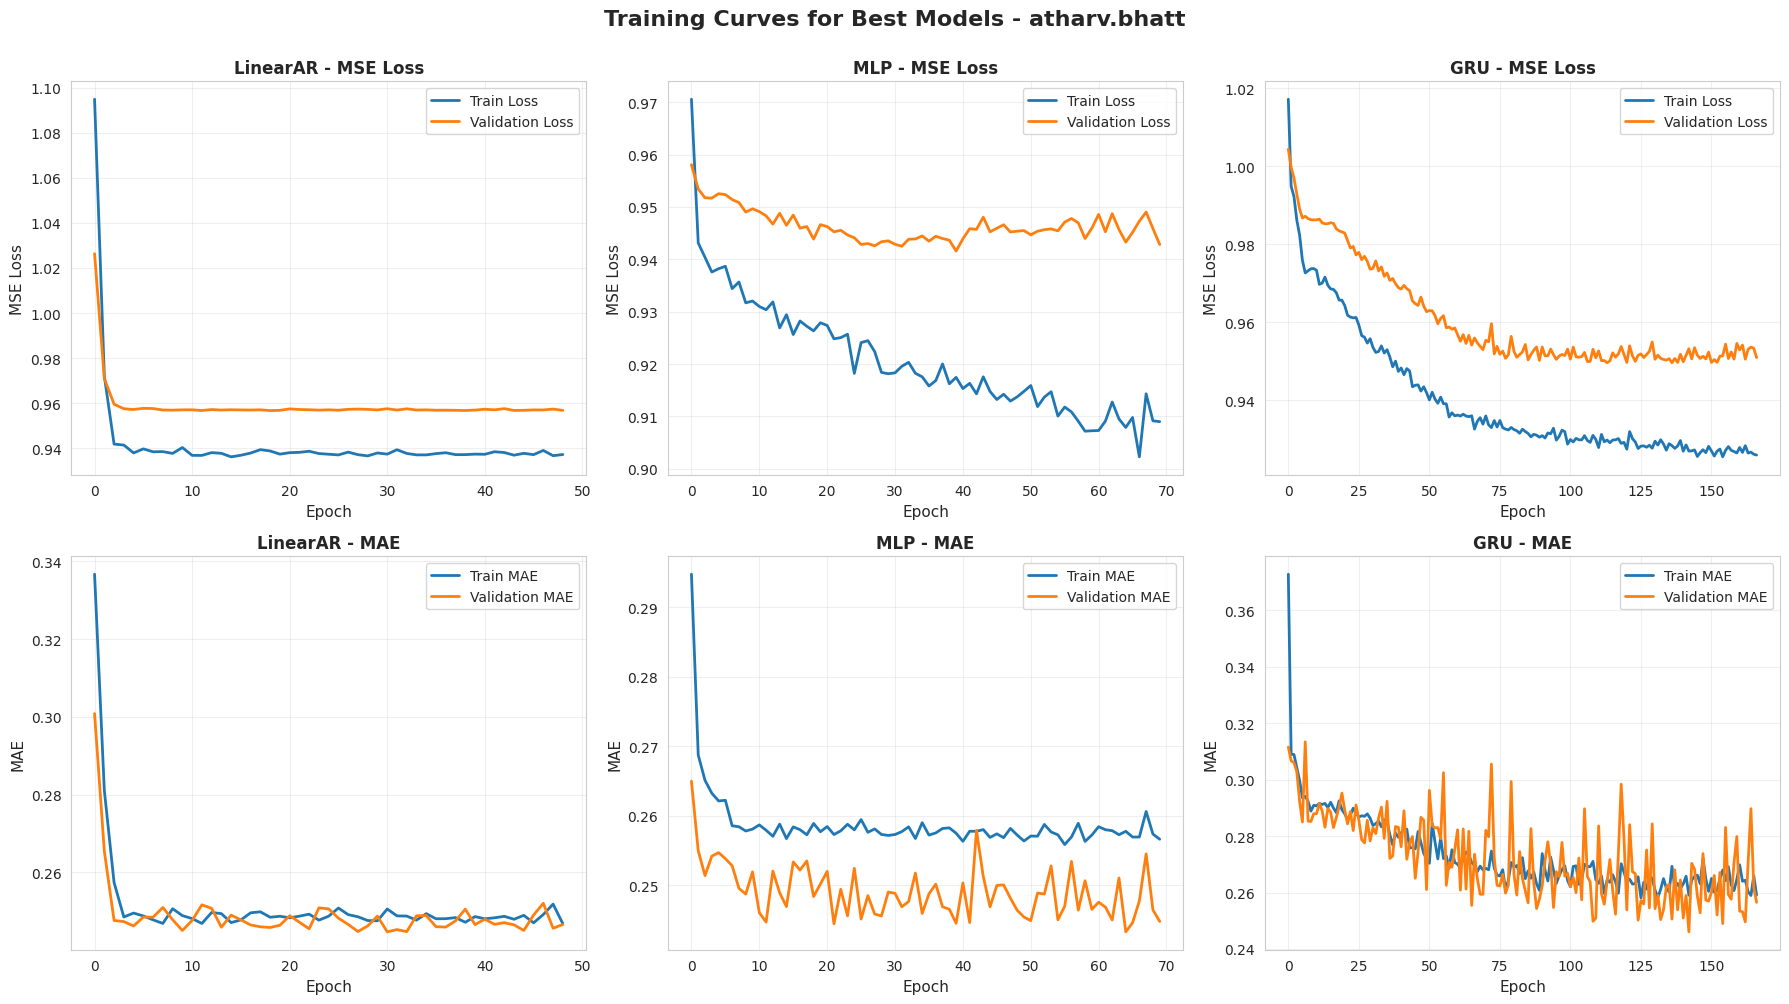


Final Training Metrics:

LinearAR:
  Final Train Loss: 0.937166
  Final Val Loss: 0.956773
  Final Train MAE: 0.246759
  Final Val MAE: 0.246546
  Best Val Loss: 0.956685

MLP:
  Final Train Loss: 0.909003
  Final Val Loss: 0.942823
  Final Train MAE: 0.256645
  Final Val MAE: 0.244825
  Best Val Loss: 0.941573

GRU:
  Final Train Loss: 0.925955
  Final Val Loss: 0.950925
  Final Train MAE: 0.259089
  Final Val MAE: 0.256522
  Best Val Loss: 0.949610


In [13]:
# Cell 11: Plot Training Curves (continued)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for idx, (name, history) in enumerate(best_histories.items()):
    # Plot MSE Loss
    ax1 = axes[0, idx]
    ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
    ax1.plot(history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_title(f'{name} - MSE Loss', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=11)
    ax1.set_ylabel('MSE Loss', fontsize=11)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Plot MAE
    ax2 = axes[1, idx]
    ax2.plot(history['train_mae'], label='Train MAE', linewidth=2)
    ax2.plot(history['val_mae'], label='Validation MAE', linewidth=2)
    ax2.set_title(f'{name} - MAE', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=11)
    ax2.set_ylabel('MAE', fontsize=11)
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

plt.suptitle(f'Training Curves for Best Models - {USERNAME}',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Print final metrics
print("\nFinal Training Metrics:")
print("="*80)
for name, history in best_histories.items():
    print(f"\n{name}:")
    print(f"  Final Train Loss: {history['train_loss'][-1]:.6f}")
    print(f"  Final Val Loss: {history['val_loss'][-1]:.6f}")
    print(f"  Final Train MAE: {history['train_mae'][-1]:.6f}")
    print(f"  Final Val MAE: {history['val_mae'][-1]:.6f}")
    print(f"  Best Val Loss: {min(history['val_loss']):.6f}")

## Analytical Extraction

In [14]:
# Cell 12: Single-Step Predictions on Test Set

# Create test datasets for each best model
test_predictions = {}
test_metrics = {}

print("Single-Step Predictions on Test Set")
print("="*80)

for name, (model, p) in best_models.items():
    print(f"\nEvaluating {name} (p={p})...")

    # Create test dataset
    X_test, y_test = create_supervised_dataset(test_data_norm, p)

    X_test_t = torch.FloatTensor(X_test)
    y_test_t = torch.FloatTensor(y_test)

    test_dataset = TensorDataset(X_test_t, y_test_t)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

    # Evaluate
    preds, targets, mae, mse, rmse = evaluate_model(model, test_loader,
                                                      train_mean, train_std)

    test_predictions[name] = (preds, targets)
    test_metrics[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

    print(f"  MAE:  {mae:.6f}")
    print(f"  MSE:  {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")

# Create metrics table
metrics_df = pd.DataFrame(test_metrics).T
print("\n" + "="*80)
print("Test Set Metrics Summary:")
print(metrics_df.to_string())
print("="*80)

Single-Step Predictions on Test Set

Evaluating LinearAR (p=10)...
  MAE:  0.038834
  MSE:  0.023474
  RMSE: 0.153212

Evaluating MLP (p=10)...
  MAE:  0.038915
  MSE:  0.023290
  RMSE: 0.152612

Evaluating GRU (p=10)...
  MAE:  0.040658
  MSE:  0.023494
  RMSE: 0.153279

Test Set Metrics Summary:
               MAE       MSE      RMSE
LinearAR  0.038834  0.023474  0.153212
MLP       0.038915  0.023290  0.152612
GRU       0.040658  0.023494  0.153279


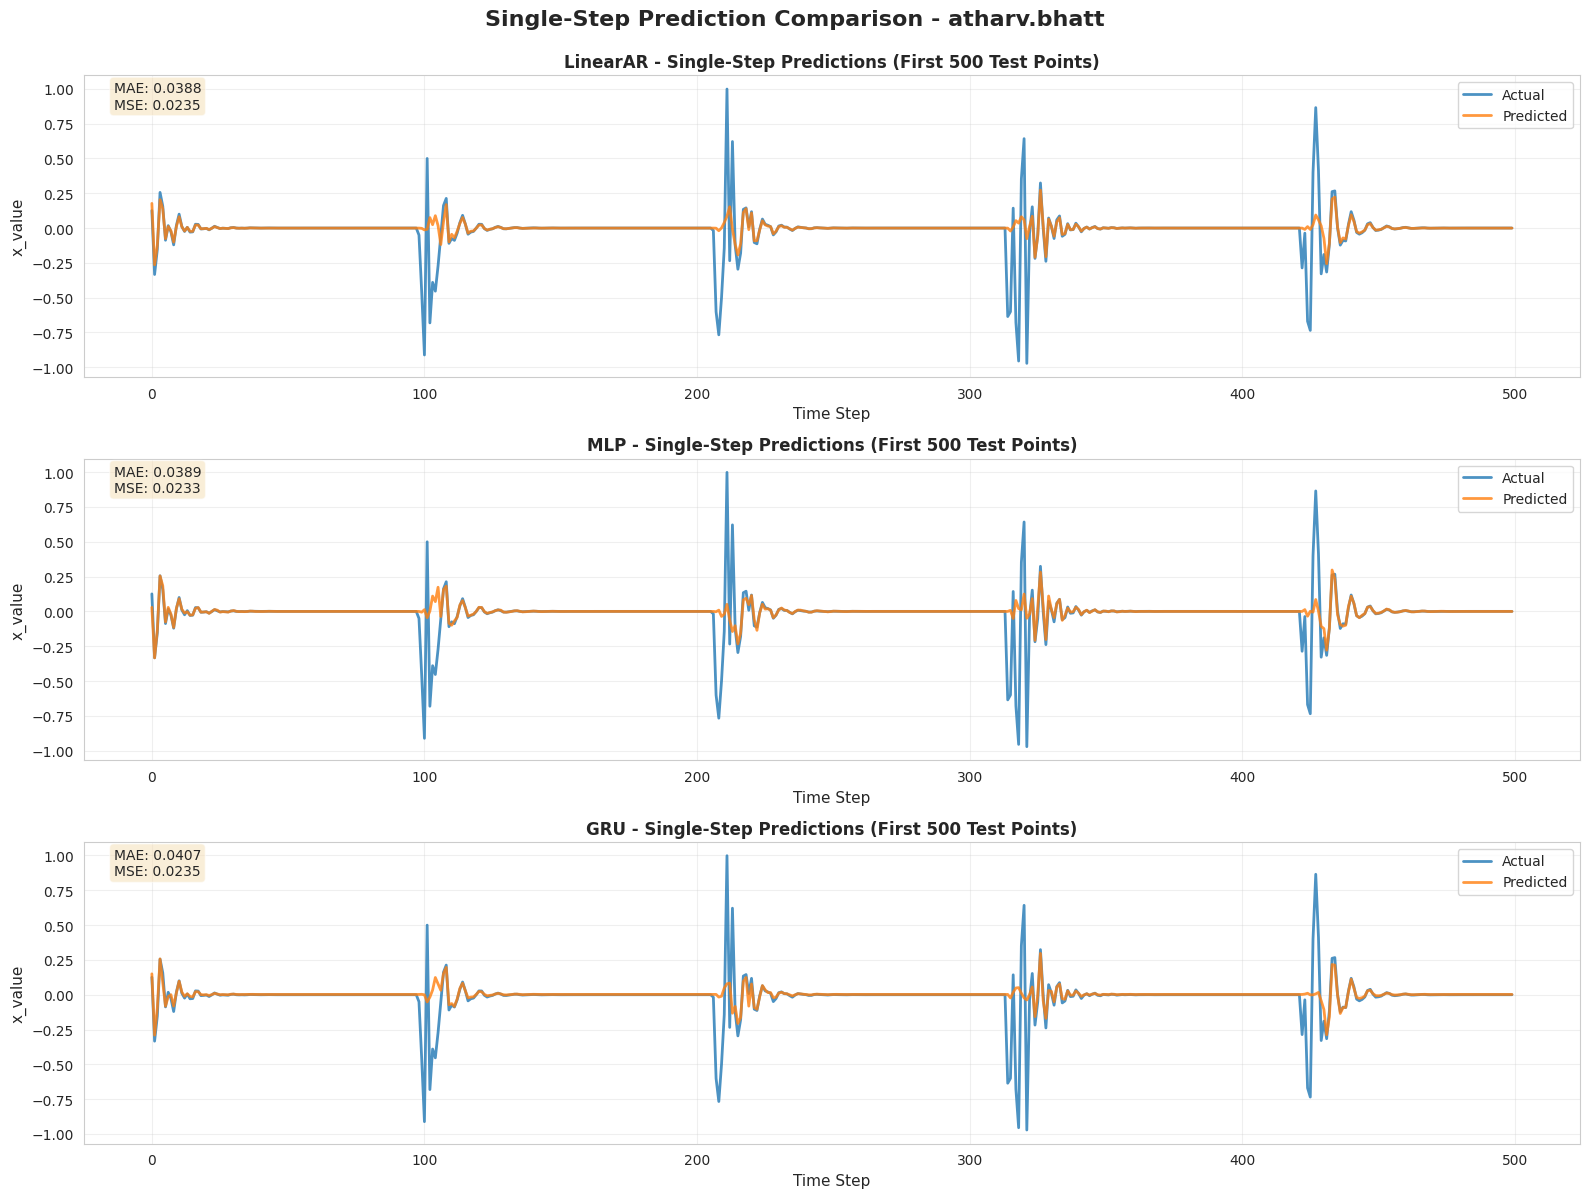

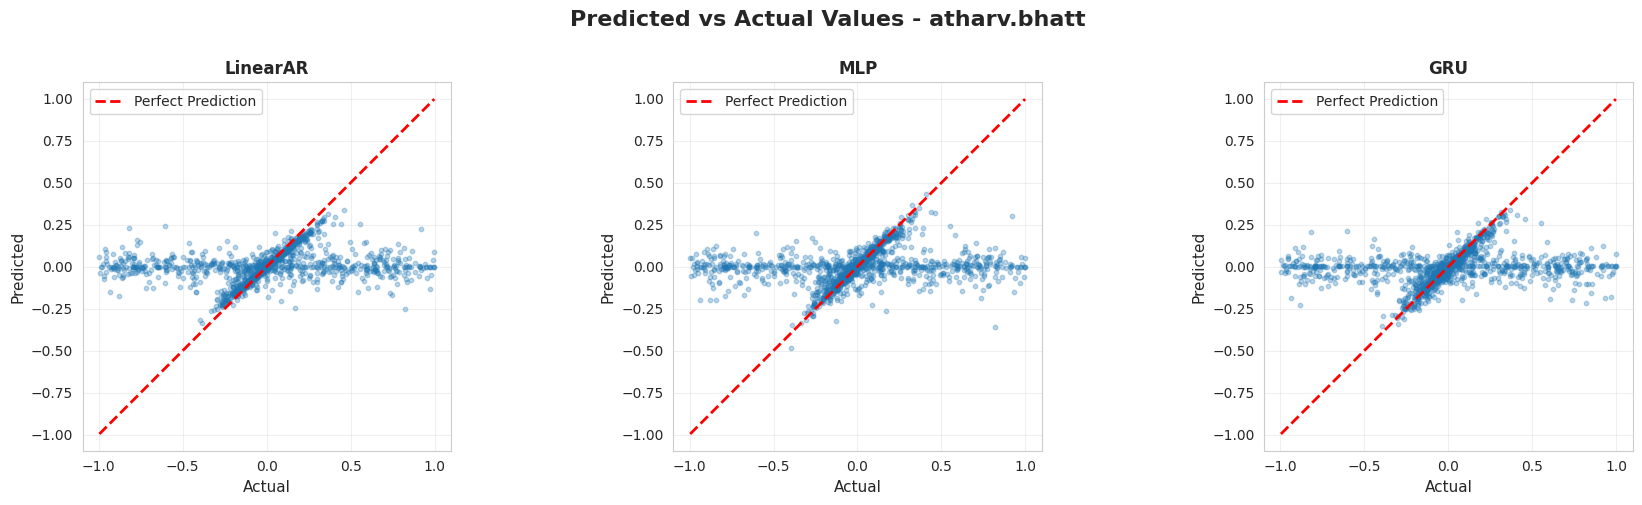

In [15]:
# Cell 13: Visualize Single-Step Predictions

# Plot predictions vs actual for a subset of test data
plot_range = 500  # Plot first 500 test points

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

for idx, name in enumerate(['LinearAR', 'MLP', 'GRU']):
    preds, targets = test_predictions[name]

    axes[idx].plot(targets[:plot_range], label='Actual', linewidth=2, alpha=0.8)
    axes[idx].plot(preds[:plot_range], label='Predicted', linewidth=2, alpha=0.8)
    axes[idx].set_title(f'{name} - Single-Step Predictions (First {plot_range} Test Points)',
                       fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time Step', fontsize=11)
    axes[idx].set_ylabel('x_value', fontsize=11)
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)

    # Add metrics text
    metrics = test_metrics[name]
    axes[idx].text(0.02, 0.98,
                  f"MAE: {metrics['MAE']:.4f}\nMSE: {metrics['MSE']:.4f}",
                  transform=axes[idx].transAxes,
                  verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                  fontsize=10)

plt.suptitle(f'Single-Step Prediction Comparison - {USERNAME}',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Scatter plots: Predicted vs Actual
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, name in enumerate(['LinearAR', 'MLP', 'GRU']):
    preds, targets = test_predictions[name]

    axes[idx].scatter(targets, preds, alpha=0.3, s=10)

    # Add diagonal line (perfect prediction)
    min_val = min(targets.min(), preds.min())
    max_val = max(targets.max(), preds.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val],
                   'r--', linewidth=2, label='Perfect Prediction')

    axes[idx].set_title(f'{name}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Actual', fontsize=11)
    axes[idx].set_ylabel('Predicted', fontsize=11)
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_aspect('equal', adjustable='box')

plt.suptitle(f'Predicted vs Actual Values - {USERNAME}',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [16]:
# Cell 14: Extract Analytical Form from Linear AR

print("Analytical Recurrence Identification")
print("="*80)

# Get best Linear AR model
linear_model, linear_p = best_models['LinearAR']
weights, bias = linear_model.get_coefficients()

print(f"\nLinear AR Model (p={linear_p}):")
print(f"{'-'*80}")
print(f"Coefficients (denormalized):")

# The model was trained on normalized data, so we need to adjust coefficients
# For normalized data: x_norm_k = θ₁·x_norm_{k-1} + ... + θₚ·x_norm_{k-p} + θ₀
# To denormalize: x_k = (x_norm_k * σ + μ)
# We need to express x_k in terms of original x values

print(f"\nNormalized form:")
equation = "x_norm_k = "
for i in range(linear_p):
    if i > 0 and weights[i] >= 0:
        equation += " + "
    elif i > 0:
        equation += " "
    equation += f"{weights[i]:.6f}·x_norm_{{k-{linear_p-i}}}"
if bias >= 0:
    equation += f" + {bias:.6f}"
else:
    equation += f" {bias:.6f}"
print(equation)

print(f"\nCoefficients:")
for i in range(linear_p):
    print(f"  θ_{i+1} (for x_{{k-{linear_p-i}}}): {weights[i]:.6f}")
print(f"  θ_0 (bias): {bias:.6f}")

# Implement analytical function
def analytical_linear_ar(history, weights, bias, train_mean, train_std):
    """
    Apply Linear AR analytical formula
    history: array of previous p values (denormalized)
    """
    # Normalize history
    history_norm = normalize(history, train_mean, train_std)

    # Apply linear combination
    prediction_norm = np.dot(weights, history_norm) + bias

    # Denormalize
    prediction = denormalize(prediction_norm, train_mean, train_std)

    return prediction

# Test analytical formula on test set
print(f"\n{'-'*80}")
print("Testing analytical formula on test set...")

# Create test data
X_test, y_test = create_supervised_dataset(test_data, linear_p)

# Apply analytical formula
analytical_preds = []
for i in range(len(X_test)):
    pred = analytical_linear_ar(X_test[i], weights, bias, train_mean, train_std)
    analytical_preds.append(pred)

analytical_preds = np.array(analytical_preds)

# Compute metrics
analytical_mae = mean_absolute_error(y_test, analytical_preds)
analytical_mse = mean_squared_error(y_test, analytical_preds)
analytical_rmse = np.sqrt(analytical_mse)

print(f"\nAnalytical Linear AR Test Metrics:")
print(f"  MAE:  {analytical_mae:.6f}")
print(f"  MSE:  {analytical_mse:.6f}")
print(f"  RMSE: {analytical_rmse:.6f}")

# Compare with neural network version
nn_preds, nn_targets = test_predictions['LinearAR']
print(f"\nNeural Network Linear AR Test Metrics:")
print(f"  MAE:  {test_metrics['LinearAR']['MAE']:.6f}")
print(f"  MSE:  {test_metrics['LinearAR']['MSE']:.6f}")
print(f"  RMSE: {test_metrics['LinearAR']['RMSE']:.6f}")

print(f"\nDifference (should be negligible):")
print(f"  MAE difference:  {abs(analytical_mae - test_metrics['LinearAR']['MAE']):.8f}")
print(f"  MSE difference:  {abs(analytical_mse - test_metrics['LinearAR']['MSE']):.8f}")

# Store analytical predictions
test_predictions['Analytical_LinearAR'] = (analytical_preds, y_test)
test_metrics['Analytical_LinearAR'] = {'MAE': analytical_mae, 'MSE': analytical_mse, 'RMSE': analytical_rmse}

Analytical Recurrence Identification

Linear AR Model (p=10):
--------------------------------------------------------------------------------
Coefficients (denormalized):

Normalized form:
x_norm_k = -0.009184·x_norm_{k-10} -0.017806·x_norm_{k-9} -0.072835·x_norm_{k-8} + 0.152580·x_norm_{k-7} + 0.089157·x_norm_{k-6} -0.079003·x_norm_{k-5} -0.065382·x_norm_{k-4} -0.037040·x_norm_{k-3} -0.042327·x_norm_{k-2} + 0.032727·x_norm_{k-1} + 0.002488

Coefficients:
  θ_1 (for x_{k-10}): -0.009184
  θ_2 (for x_{k-9}): -0.017806
  θ_3 (for x_{k-8}): -0.072835
  θ_4 (for x_{k-7}): 0.152580
  θ_5 (for x_{k-6}): 0.089157
  θ_6 (for x_{k-5}): -0.079003
  θ_7 (for x_{k-4}): -0.065382
  θ_8 (for x_{k-3}): -0.037040
  θ_9 (for x_{k-2}): -0.042327
  θ_10 (for x_{k-1}): 0.032727
  θ_0 (bias): 0.002488

--------------------------------------------------------------------------------
Testing analytical formula on test set...

Analytical Linear AR Test Metrics:
  MAE:  0.038834
  MSE:  0.023474
  RMSE: 0.153

In [17]:
# Cell 15: Try to Extract Analytical Form from Simple GRU

print("\nAttempting to Extract Analytical Form from GRU")
print("="*80)

# Get the GRU model with smallest hidden size
gru_results = results_df[results_df['model_type'] == 'GRU'].sort_values('parameters')
simplest_gru_result = gru_results.iloc[0]

print(f"\nUsing simplest GRU: p={simplest_gru_result['history_length']}, "
      f"config={simplest_gru_result['config']}, "
      f"parameters={simplest_gru_result['parameters']}")

# Train a very simple GRU with h=1 for analytical extraction
print(f"\n{'-'*80}")
print("Training ultra-simple GRU (h=1, layers=1) for analytical extraction...")
print(f"{'-'*80}")

p_gru = int(simplest_gru_result['history_length'])

X_train, y_train = create_supervised_dataset(train_data_norm, p_gru)
X_val, y_val = create_supervised_dataset(val_data_norm, p_gru)

X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

simple_gru = GRUPredictor(p_gru, hidden_size=1, num_layers=1).to(device)
simple_gru, _ = train_model(simple_gru, train_loader, val_loader,
                            num_epochs=200, learning_rate=0.001,
                            patience=20, model_name="SimpleGRU_h1")

# Extract GRU parameters
print(f"\n{'-'*80}")
print("GRU Weight Analysis:")
print(f"{'-'*80}")

simple_gru.eval()
with torch.no_grad():
    # Get GRU parameters
    for name, param in simple_gru.gru.named_parameters():
        print(f"\n{name}:")
        print(f"  Shape: {param.shape}")
        print(f"  Values: {param.cpu().numpy().flatten()}")

    # Get FC layer parameters
    fc_weight = simple_gru.fc.weight.data.cpu().numpy()
    fc_bias = simple_gru.fc.bias.data.cpu().numpy()
    print(f"\nFC Layer weight: {fc_weight}")
    print(f"FC Layer bias: {fc_bias}")

print(f"\n{'-'*80}")
print("Note: For GRU with h>1, the recurrence becomes multi-dimensional")
print("and extracting a simple closed-form expression is not straightforward.")
print("The GRU equations are:")
print("  r_t = σ(W_ir·x_t + b_ir + W_hr·h_{t-1} + b_hr)")
print("  z_t = σ(W_iz·x_t + b_iz + W_hz·h_{t-1} + b_hz)")
print("  n_t = tanh(W_in·x_t + b_in + r_t⊙(W_hn·h_{t-1} + b_hn))")
print("  h_t = (1 - z_t)⊙n_t + z_t⊙h_{t-1}")
print("  y_t = W_fc·h_t + b_fc")
print("\nFor analytical interpretation, Linear AR is more suitable.")
print("="*80)


Attempting to Extract Analytical Form from GRU

Using simplest GRU: p=5, config=h=2,l=1, parameters=33

--------------------------------------------------------------------------------
Training ultra-simple GRU (h=1, layers=1) for analytical extraction...
--------------------------------------------------------------------------------
Epoch [1/200] - Train Loss: 1.052361, Val Loss: 1.040143, Val MAE: 0.324960
Epoch [20/200] - Train Loss: 0.990874, Val Loss: 1.008232, Val MAE: 0.304828
Epoch [40/200] - Train Loss: 0.987704, Val Loss: 1.007643, Val MAE: 0.303630
Epoch [60/200] - Train Loss: 0.984204, Val Loss: 1.005571, Val MAE: 0.296173
Epoch [80/200] - Train Loss: 0.983231, Val Loss: 1.003637, Val MAE: 0.292149
Epoch [100/200] - Train Loss: 0.977701, Val Loss: 1.003420, Val MAE: 0.290947
Epoch [120/200] - Train Loss: 0.976762, Val Loss: 1.002718, Val MAE: 0.297899
Epoch [140/200] - Train Loss: 0.977908, Val Loss: 1.002024, Val MAE: 0.291998
Epoch [160/200] - Train Loss: 0.977224, Val 

Residual Analysis


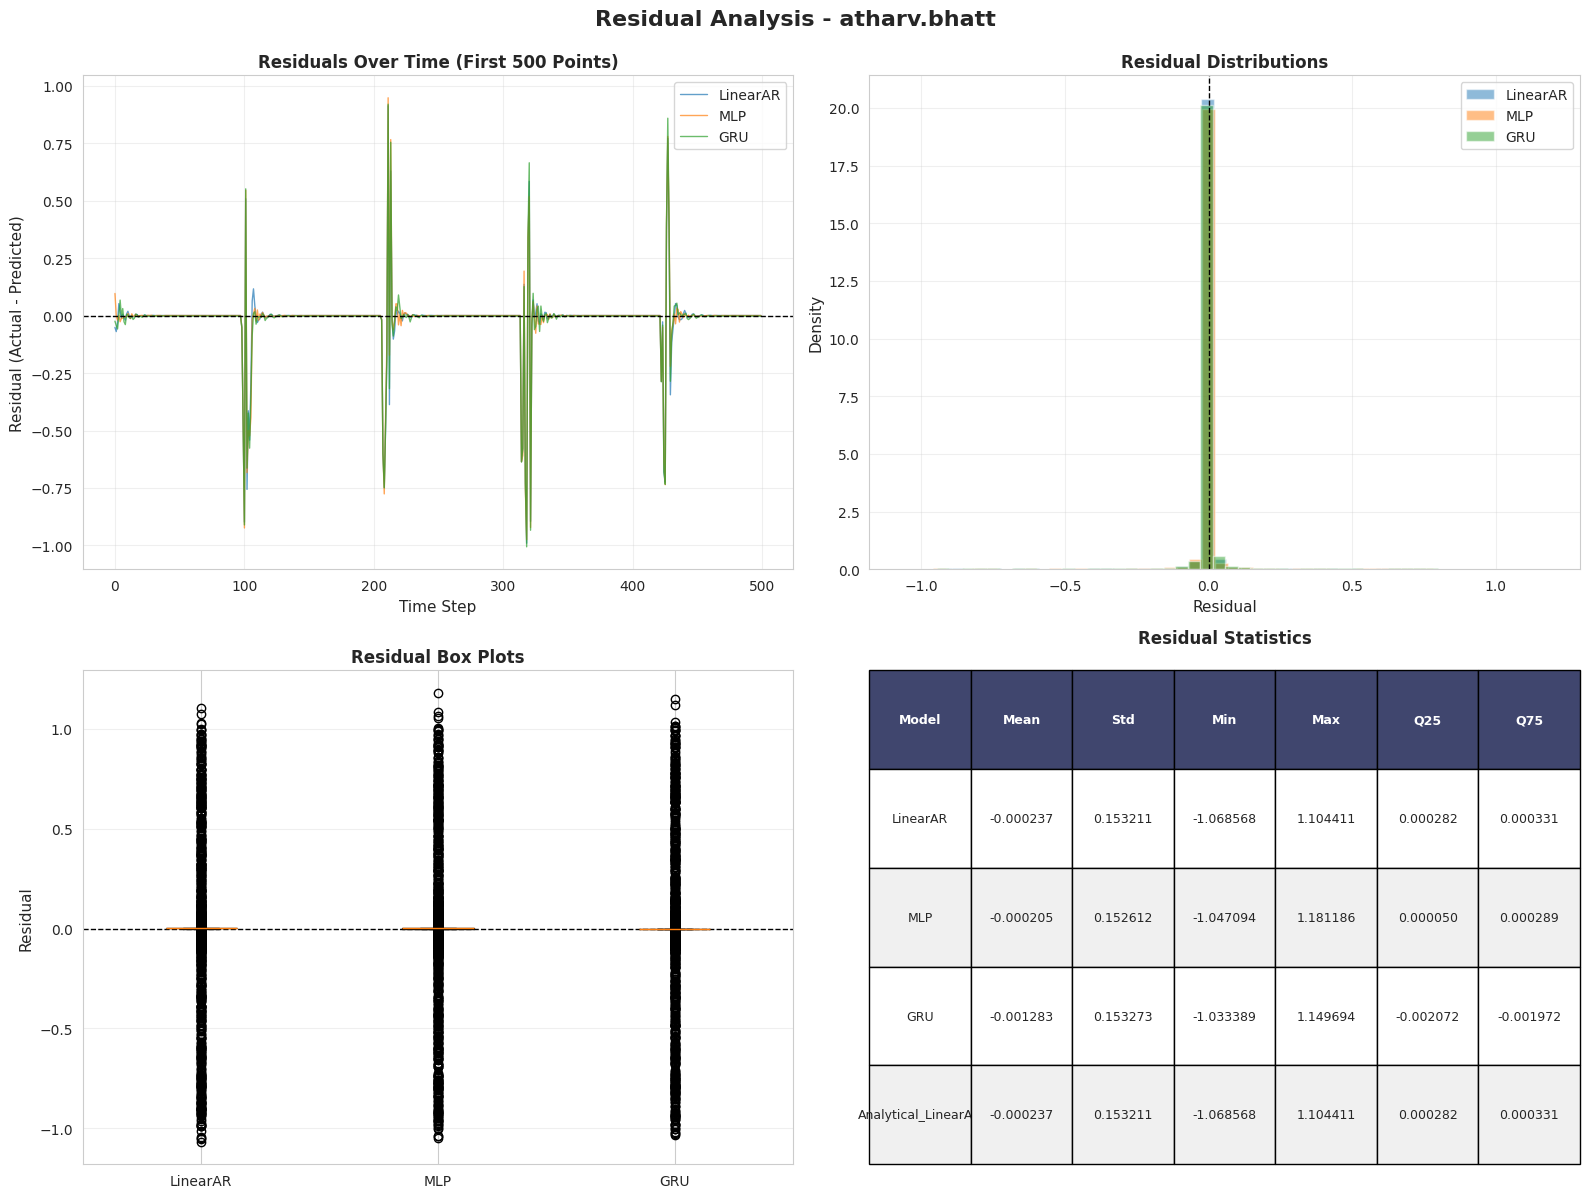


Residual Statistics Summary:

LinearAR:
  Mean: -0.000237 (should be close to 0)
  Std:  0.153211
  Min:  -1.068568
  Max:  1.104411

MLP:
  Mean: -0.000205 (should be close to 0)
  Std:  0.152612
  Min:  -1.047094
  Max:  1.181186

GRU:
  Mean: -0.001283 (should be close to 0)
  Std:  0.153273
  Min:  -1.033389
  Max:  1.149694

Analytical_LinearAR:
  Mean: -0.000237 (should be close to 0)
  Std:  0.153211
  Min:  -1.068568
  Max:  1.104411


In [18]:
# Cell 16: Residual Analysis

print("Residual Analysis")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Calculate residuals for each model
residuals_dict = {}

for name in ['LinearAR', 'MLP', 'GRU', 'Analytical_LinearAR']:
    preds, targets = test_predictions[name]
    residuals = targets - preds
    residuals_dict[name] = residuals

# Plot 1: Residuals over time
ax = axes[0, 0]
plot_len = 500
for name in ['LinearAR', 'MLP', 'GRU']:
    residuals = residuals_dict[name]
    ax.plot(residuals[:plot_len], label=name, alpha=0.7, linewidth=1)
ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax.set_title('Residuals Over Time (First 500 Points)', fontsize=12, fontweight='bold')
ax.set_xlabel('Time Step', fontsize=11)
ax.set_ylabel('Residual (Actual - Predicted)', fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Residual distributions
ax = axes[0, 1]
for name in ['LinearAR', 'MLP', 'GRU']:
    residuals = residuals_dict[name]
    ax.hist(residuals, bins=50, alpha=0.5, label=name, density=True)
ax.axvline(x=0, color='k', linestyle='--', linewidth=1)
ax.set_title('Residual Distributions', fontsize=12, fontweight='bold')
ax.set_xlabel('Residual', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Box plots of residuals
ax = axes[1, 0]
residual_data = [residuals_dict[name] for name in ['LinearAR', 'MLP', 'GRU']]
bp = ax.boxplot(residual_data, labels=['LinearAR', 'MLP', 'GRU'], patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightblue', 'lightgreen', 'lightcoral']):
    patch.set_facecolor(color)
ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax.set_title('Residual Box Plots', fontsize=12, fontweight='bold')
ax.set_ylabel('Residual', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Residual statistics table
ax = axes[1, 1]
ax.axis('off')

stats_data = []
for name in ['LinearAR', 'MLP', 'GRU', 'Analytical_LinearAR']:
    residuals = residuals_dict[name]
    stats_data.append([
        name,
        f"{np.mean(residuals):.6f}",
        f"{np.std(residuals):.6f}",
        f"{np.min(residuals):.6f}",
        f"{np.max(residuals):.6f}",
        f"{np.percentile(residuals, 25):.6f}",
        f"{np.percentile(residuals, 75):.6f}"
    ])

table = ax.table(cellText=stats_data,
                colLabels=['Model', 'Mean', 'Std', 'Min', 'Max', 'Q25', 'Q75'],
                cellLoc='center',
                loc='center',
                bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Style header
for i in range(7):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(stats_data) + 1):
    for j in range(7):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')

ax.set_title('Residual Statistics', fontsize=12, fontweight='bold', pad=20)

plt.suptitle(f'Residual Analysis - {USERNAME}', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Print statistical summary
print("\nResidual Statistics Summary:")
print("="*80)
for name in ['LinearAR', 'MLP', 'GRU', 'Analytical_LinearAR']:
    residuals = residuals_dict[name]
    print(f"\n{name}:")
    print(f"  Mean: {np.mean(residuals):.6f} (should be close to 0)")
    print(f"  Std:  {np.std(residuals):.6f}")
    print(f"  Min:  {np.min(residuals):.6f}")
    print(f"  Max:  {np.max(residuals):.6f}")

## Autoregressive Evaluation

In [19]:
# Cell 17: Autoregressive Generation Function

def autoregressive_forecast(initial_history, model, forecast_steps,
                            train_mean, train_std, model_type='neural'):
    """
    Generate multi-step forecast autoregressively

    Args:
        initial_history: Initial p values (denormalized)
        model: Trained model or (weights, bias) for analytical
        forecast_steps: Number of steps to forecast
        train_mean, train_std: Normalization parameters
        model_type: 'neural' or 'analytical'

    Returns:
        forecasts: Array of forecasted values (denormalized)
    """
    forecasts = []
    history = initial_history.copy()

    if model_type == 'neural':
        model.eval()
        with torch.no_grad():
            for _ in range(forecast_steps):
                # Normalize history
                history_norm = normalize(history, train_mean, train_std)

                # Prepare input
                X = torch.FloatTensor(history_norm).unsqueeze(0).to(device)

                # Predict
                pred_norm = model(X).cpu().numpy()[0]

                # Denormalize
                pred = denormalize(pred_norm, train_mean, train_std)

                forecasts.append(pred)

                # Update history (shift left and add new prediction)
                history = np.append(history[1:], pred)

    elif model_type == 'analytical':
        weights, bias = model
        for _ in range(forecast_steps):
            pred = analytical_linear_ar(history, weights, bias, train_mean, train_std)
            forecasts.append(pred)
            history = np.append(history[1:], pred)

    return np.array(forecasts)


# Test autoregressive forecast
print("Testing Autoregressive Forecasting")
print("="*80)

# Use a section from the test set as initial history
test_start_idx = 100
forecast_lengths = [1, 5, 10, 20, 50, 100, 200]

# Get initial history for each model (using their respective p values)
for name, (model, p) in best_models.items():
    print(f"\n{name} (p={p}):")

    # Get initial history
    initial_history = test_data[test_start_idx:test_start_idx + p]
    actual_future = test_data[test_start_idx + p:test_start_idx + p + max(forecast_lengths)]

    # Test a 10-step forecast
    forecast = autoregressive_forecast(initial_history, model, 10,
                                      train_mean, train_std, model_type='neural')

    print(f"  Initial history: {initial_history}")
    print(f"  10-step forecast: {forecast}")
    print(f"  Actual values: {actual_future[:10]}")
    print(f"  MAE: {mean_absolute_error(actual_future[:10], forecast):.6f}")

# Test analytical model
linear_model, linear_p = best_models['LinearAR']
weights, bias = linear_model.get_coefficients()

print(f"\nAnalytical Linear AR (p={linear_p}):")
initial_history = test_data[test_start_idx:test_start_idx + linear_p]
actual_future = test_data[test_start_idx + linear_p:test_start_idx + linear_p + max(forecast_lengths)]

forecast = autoregressive_forecast(initial_history, (weights, bias), 10,
                                  train_mean, train_std, model_type='analytical')

print(f"  Initial history: {initial_history}")
print(f"  10-step forecast: {forecast}")
print(f"  Actual values: {actual_future[:10]}")
print(f"  MAE: {mean_absolute_error(actual_future[:10], forecast):.6f}")

print("\n" + "="*80)

Testing Autoregressive Forecasting

LinearAR (p=10):
  Initial history: [ 0.       -0.       -0.       -0.        0.        0.        0.
 -0.       -0.050492 -0.460818]
  10-step forecast: [-0.01325851  0.02062693  0.02129165  0.03411827  0.03190797 -0.05059347
 -0.07542265  0.02854262  0.01558483  0.01182454]
  Actual values: [-0.911646  0.499772 -0.681221 -0.390133 -0.453214 -0.271535 -0.055137
  0.161863  0.212867 -0.109849]
  MAE: 0.368292

MLP (p=10):
  Initial history: [ 0.       -0.       -0.       -0.        0.        0.        0.
 -0.       -0.050492 -0.460818]
  10-step forecast: [ 0.0125424  -0.06056163  0.05932486 -0.00466365  0.02221998 -0.0448577
 -0.05286956  0.01790875  0.01086535  0.02392118]
  Actual values: [-0.911646  0.499772 -0.681221 -0.390133 -0.453214 -0.271535 -0.055137
  0.161863  0.212867 -0.109849]
  MAE: 0.379464

GRU (p=10):
  Initial history: [ 0.       -0.       -0.       -0.        0.        0.        0.
 -0.       -0.050492 -0.460818]
  10-step foreca

In [20]:
# Cell 18: Multi-Step Forecasting Evaluation

print("Multi-Step Forecasting Evaluation")
print("="*80)

forecast_lengths = [1, 5, 10, 20, 50, 100, 200]
num_test_windows = 20  # Number of different starting points to test

# Store results
multistep_results = {length: {model: [] for model in ['LinearAR', 'MLP', 'GRU', 'Analytical_LinearAR']}
                    for length in forecast_lengths}

# Models to test
models_to_test = [
    ('LinearAR', best_models['LinearAR'], 'neural'),
    ('MLP', best_models['MLP'], 'neural'),
    ('GRU', best_models['GRU'], 'neural'),
    ('Analytical_LinearAR', (weights, bias), 'analytical')
]

print("\nGenerating forecasts from multiple starting points...")

for window_idx in range(num_test_windows):
    # Randomly select starting point in test set
    max_start = len(test_data) - max(forecast_lengths) - 10
    start_idx = np.random.randint(10, max_start)

    for name, model_info, model_type in models_to_test:
        if name == 'Analytical_LinearAR':
            p = linear_p
            model = model_info
        else:
            model, p = model_info

        # Get initial history
        initial_history = test_data[start_idx:start_idx + p]

        # For each forecast length
        for flen in forecast_lengths:
            # Get actual future values
            actual = test_data[start_idx + p:start_idx + p + flen]

            # Generate forecast
            forecast = autoregressive_forecast(initial_history, model, flen,
                                              train_mean, train_std, model_type=model_type)

            # Compute metrics
            mae = mean_absolute_error(actual, forecast)
            mse = mean_squared_error(actual, forecast)

            multistep_results[flen][name].append({'MAE': mae, 'MSE': mse})

# Aggregate results
aggregated_results = {}
for flen in forecast_lengths:
    aggregated_results[flen] = {}
    for model in ['LinearAR', 'MLP', 'GRU', 'Analytical_LinearAR']:
        maes = [r['MAE'] for r in multistep_results[flen][model]]
        mses = [r['MSE'] for r in multistep_results[flen][model]]

        aggregated_results[flen][model] = {
            'MAE_mean': np.mean(maes),
            'MAE_std': np.std(maes),
            'MSE_mean': np.mean(mses),
            'MSE_std': np.std(mses)
        }

# Print results
print("\n" + "="*80)
print("Multi-Step Forecasting Results (Mean ± Std over 20 windows)")
print("="*80)

for flen in forecast_lengths:
    print(f"\nForecast Length: {flen} steps")
    print("-" * 80)
    for model in ['LinearAR', 'MLP', 'GRU', 'Analytical_LinearAR']:
        results = aggregated_results[flen][model]
        print(f"  {model:25s} MAE: {results['MAE_mean']:.6f} ± {results['MAE_std']:.6f}  "
              f"MSE: {results['MSE_mean']:.6f} ± {results['MSE_std']:.6f}")

print("\n" + "="*80)

Multi-Step Forecasting Evaluation

Generating forecasts from multiple starting points...

Multi-Step Forecasting Results (Mean ± Std over 20 windows)

Forecast Length: 1 steps
--------------------------------------------------------------------------------
  LinearAR                  MAE: 0.009730 ± 0.023096  MSE: 0.000628 ± 0.001779
  MLP                       MAE: 0.012166 ± 0.029797  MSE: 0.001036 ± 0.003593
  GRU                       MAE: 0.009975 ± 0.019859  MSE: 0.000494 ± 0.001517
  Analytical_LinearAR       MAE: 0.009730 ± 0.023096  MSE: 0.000628 ± 0.001779

Forecast Length: 5 steps
--------------------------------------------------------------------------------
  LinearAR                  MAE: 0.005645 ± 0.010690  MSE: 0.000232 ± 0.000585
  MLP                       MAE: 0.007696 ± 0.016140  MSE: 0.000447 ± 0.001179
  GRU                       MAE: 0.007815 ± 0.014024  MSE: 0.000310 ± 0.000932
  Analytical_LinearAR       MAE: 0.005645 ± 0.010690  MSE: 0.000232 ± 0.000585

For

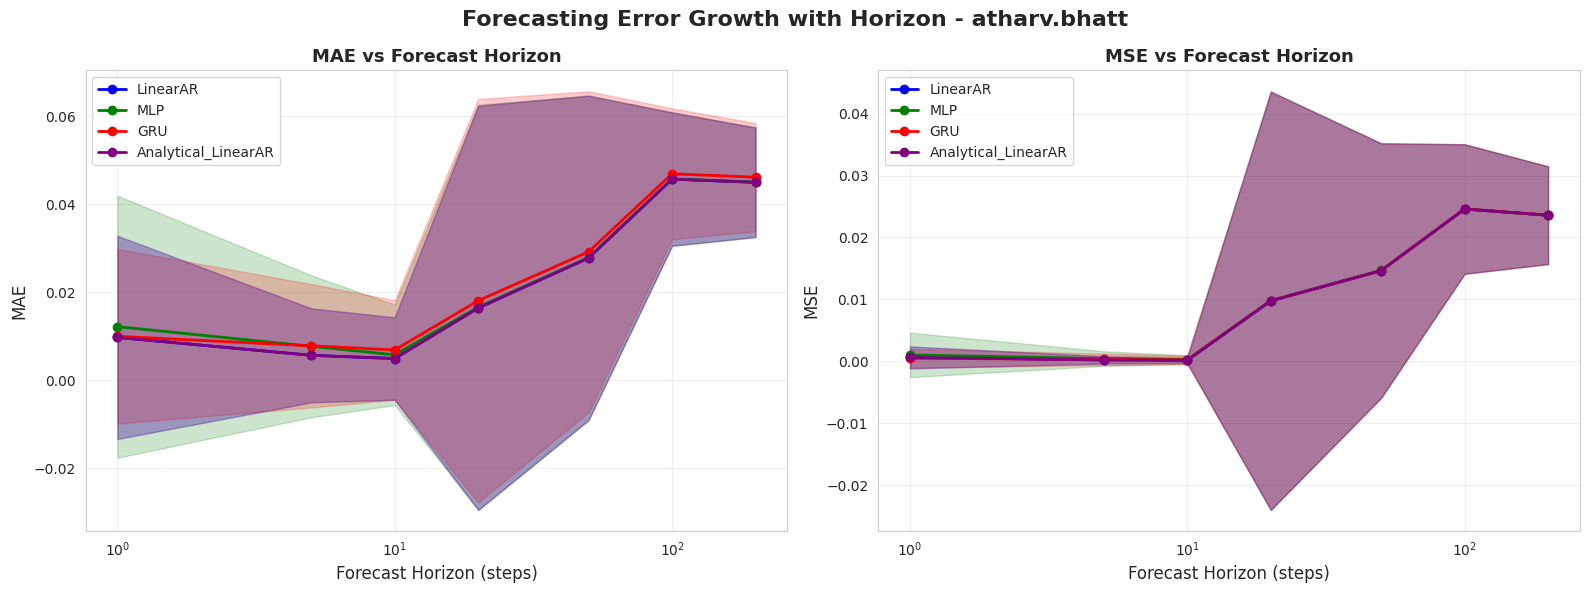


Key Observations:
1. Error Accumulation: All models show increasing error with longer horizons
2. Model Comparison:
   LinearAR: MAE at 200 steps = 0.044989
   MLP: MAE at 200 steps = 0.045038
   GRU: MAE at 200 steps = 0.046165
   Analytical_LinearAR: MAE at 200 steps = 0.044989

3. Best performing model at long horizons: LinearAR

4. Analytical vs Neural LinearAR:
   Difference in MAE: 0.00000000
   (Should be negligible, confirming analytical extraction is correct)



In [22]:
# Cell 19: Plot Multi-Step Forecasting Error vs Horizon

# Prepare data for plotting
forecast_lengths_plot = forecast_lengths  # Use the forecast_lengths from Cell 18
models_plot = ['LinearAR', 'MLP', 'GRU', 'Analytical_LinearAR']
colors = {'LinearAR': 'blue', 'MLP': 'green', 'GRU': 'red', 'Analytical_LinearAR': 'purple'}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot MAE vs Forecast Horizon
ax = axes[0]
for model in models_plot:
    mae_means = [aggregated_results[flen][model]['MAE_mean'] for flen in forecast_lengths_plot]
    mae_stds = [aggregated_results[flen][model]['MAE_std'] for flen in forecast_lengths_plot]

    ax.plot(forecast_lengths_plot, mae_means, marker='o', linewidth=2,
           label=model, color=colors[model])
    ax.fill_between(forecast_lengths_plot,
                    np.array(mae_means) - np.array(mae_stds),
                    np.array(mae_means) + np.array(mae_stds),
                    alpha=0.2, color=colors[model])

ax.set_xlabel('Forecast Horizon (steps)', fontsize=12)
ax.set_ylabel('MAE', fontsize=12)
ax.set_title('MAE vs Forecast Horizon', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

# Plot MSE vs Forecast Horizon
ax = axes[1]
for model in models_plot:
    mse_means = [aggregated_results[flen][model]['MSE_mean'] for flen in forecast_lengths_plot]
    mse_stds = [aggregated_results[flen][model]['MSE_std'] for flen in forecast_lengths_plot]

    ax.plot(forecast_lengths_plot, mse_means, marker='o', linewidth=2,
           label=model, color=colors[model])
    ax.fill_between(forecast_lengths_plot,
                    np.array(mse_means) - np.array(mse_stds),
                    np.array(mse_means) + np.array(mse_stds),
                    alpha=0.2, color=colors[model])

ax.set_xlabel('Forecast Horizon (steps)', fontsize=12)
ax.set_ylabel('MSE', fontsize=12)
ax.set_title('MSE vs Forecast Horizon', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

plt.suptitle(f'Forecasting Error Growth with Horizon - {USERNAME}',
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Observation analysis
print("\nKey Observations:")
print("="*80)
print("1. Error Accumulation: All models show increasing error with longer horizons")
print("2. Model Comparison:")

# Compare final errors
final_horizon = max(forecast_lengths_plot)
final_errors = {model: aggregated_results[final_horizon][model]['MAE_mean']
                for model in models_plot}
best_model = min(final_errors, key=final_errors.get)

for model in models_plot:
    mae = aggregated_results[final_horizon][model]['MAE_mean']
    print(f"   {model}: MAE at {final_horizon} steps = {mae:.6f}")

print(f"\n3. Best performing model at long horizons: {best_model}")

# Compare analytical vs neural LinearAR
analytical_mae = aggregated_results[final_horizon]['Analytical_LinearAR']['MAE_mean']
neural_mae = aggregated_results[final_horizon]['LinearAR']['MAE_mean']
print(f"\n4. Analytical vs Neural LinearAR:")
print(f"   Difference in MAE: {abs(analytical_mae - neural_mae):.8f}")
print(f"   (Should be negligible, confirming analytical extraction is correct)")

print("\n" + "="*80)

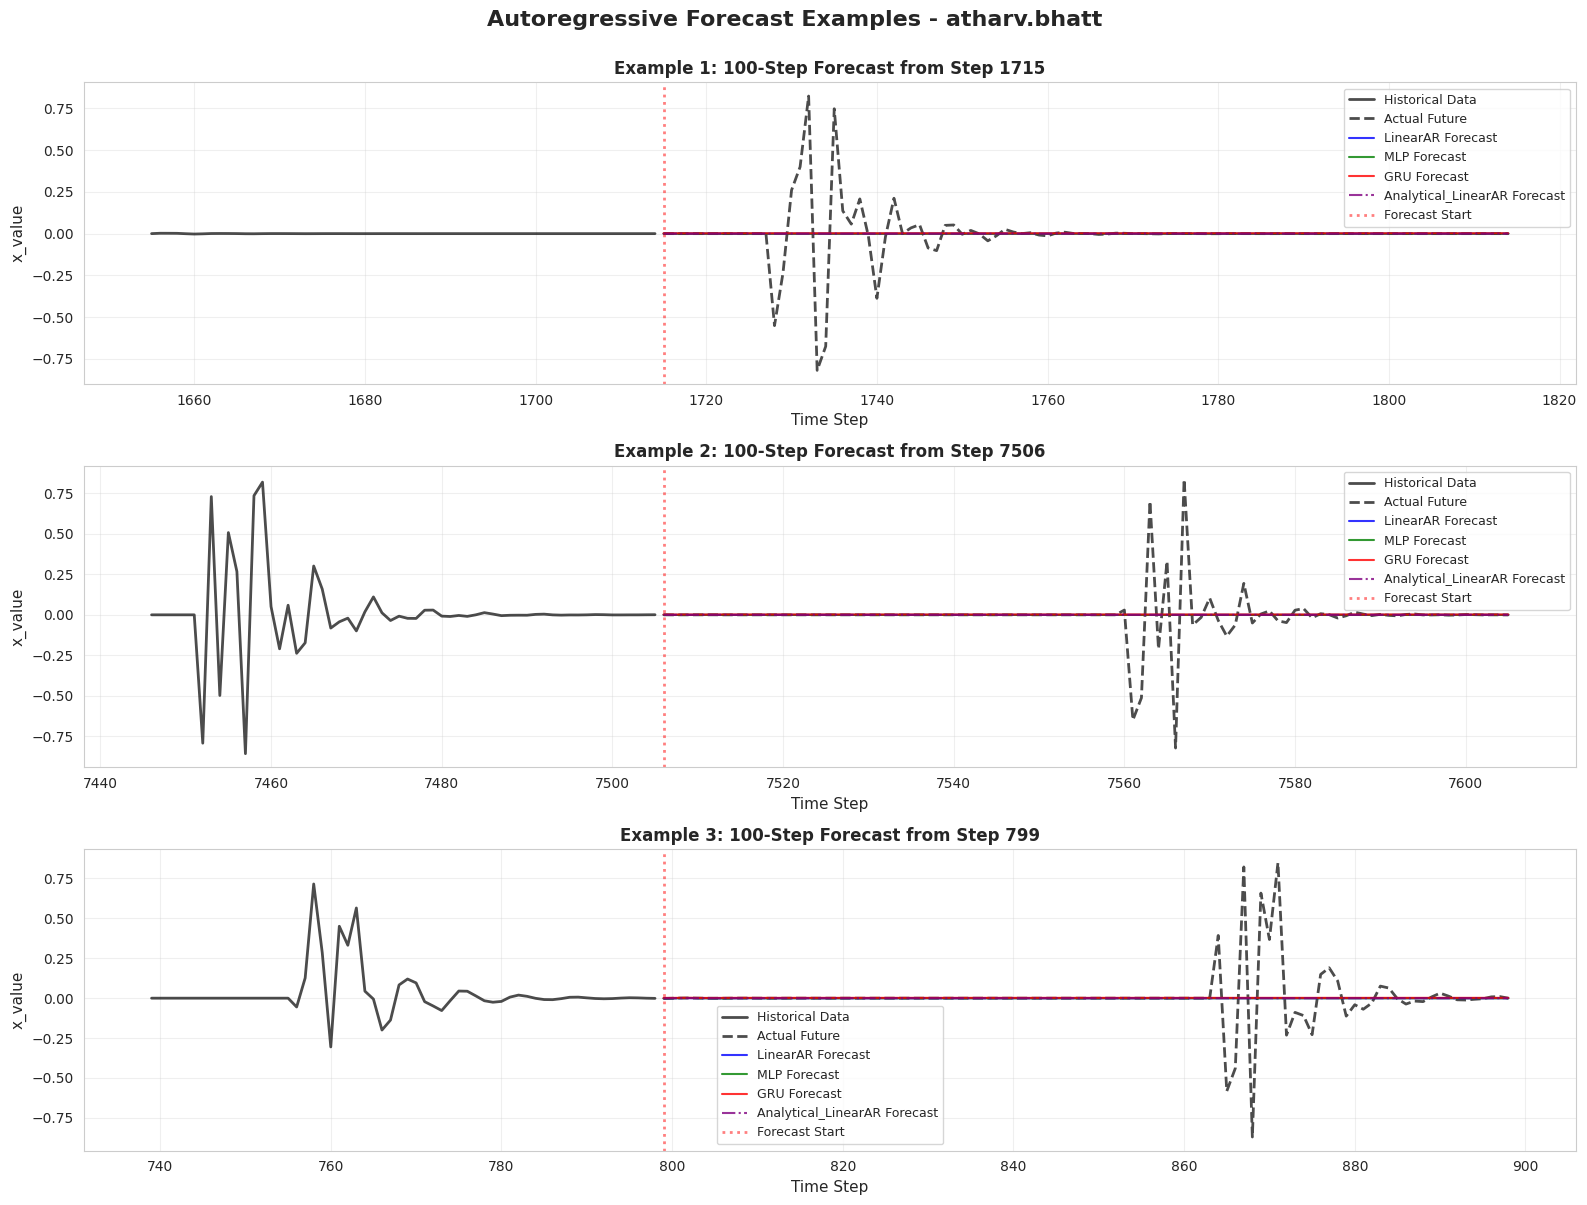

In [23]:
# Cell 20: Visualize Sample Forecasts

# Select a few test windows and visualize forecasts
num_examples = 3
forecast_horizon = 100

fig, axes = plt.subplots(num_examples, 1, figsize=(16, 4*num_examples))
if num_examples == 1:
    axes = [axes]

for example_idx in range(num_examples):
    ax = axes[example_idx]

    # Select random starting point
    max_start = len(test_data) - forecast_horizon - 20
    start_idx = np.random.randint(20, max_start)

    # Plot actual values (including history + future)
    plot_history_len = 50
    history_start = max(0, start_idx - plot_history_len)

    time_axis_history = range(history_start, start_idx + linear_p)
    time_axis_future = range(start_idx + linear_p, start_idx + linear_p + forecast_horizon)

    # Plot history
    ax.plot(time_axis_history,
           test_data[history_start:start_idx + linear_p],
           'k-', linewidth=2, label='Historical Data', alpha=0.7)

    # Plot actual future
    ax.plot(time_axis_future,
           test_data[start_idx + linear_p:start_idx + linear_p + forecast_horizon],
           'k--', linewidth=2, label='Actual Future', alpha=0.7)

    # Generate and plot forecasts for each model
    for name, model_info, model_type in models_to_test:
        if name == 'Analytical_LinearAR':
            p = linear_p
            model = model_info
            linestyle = '-.'
        else:
            model, p = model_info
            linestyle = '-'

        # Get initial history
        initial_history = test_data[start_idx:start_idx + p]

        # Generate forecast
        forecast = autoregressive_forecast(initial_history, model, forecast_horizon,
                                          train_mean, train_std, model_type=model_type)

        # Plot forecast
        ax.plot(time_axis_future, forecast, linestyle=linestyle, linewidth=1.5,
               label=f'{name} Forecast', color=colors.get(name, 'gray'), alpha=0.8)

    ax.axvline(x=start_idx + linear_p, color='red', linestyle=':', linewidth=2,
              label='Forecast Start', alpha=0.5)
    ax.set_xlabel('Time Step', fontsize=11)
    ax.set_ylabel('x_value', fontsize=11)
    ax.set_title(f'Example {example_idx+1}: {forecast_horizon}-Step Forecast from Step {start_idx+linear_p}',
                fontsize=12, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Autoregressive Forecast Examples - {USERNAME}',
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Parsimony & Stability

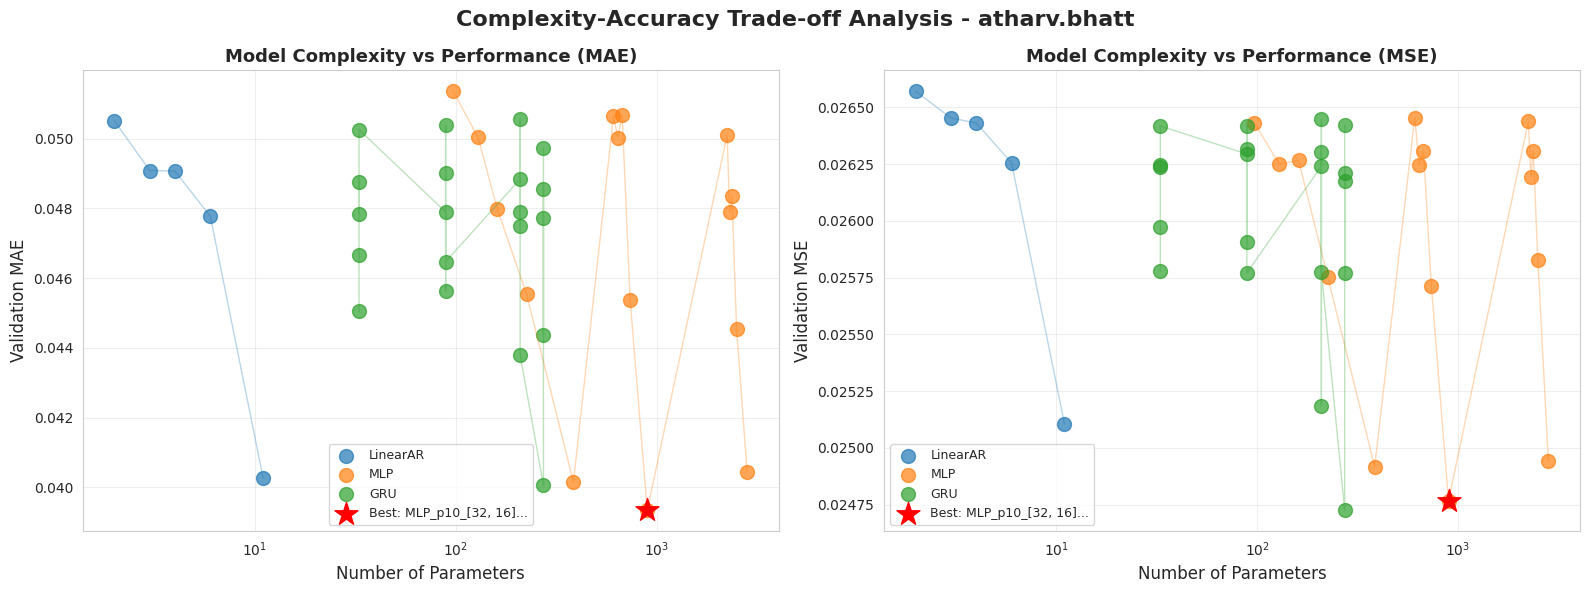


Parsimony Analysis

Best model (lowest validation MAE):
  Model: MLP_p10_[32, 16]
  Type: MLP
  History Length: 10
  Parameters: 897
  Validation MAE: 0.039348
  Validation MSE: 0.024767

Simplest model within 5% of best performance:
  Model: LinearAR_p10_None
  Type: LinearAR
  History Length: 10
  Parameters: 11
  Validation MAE: 0.040264
  Performance degradation: 2.33%
  Parameter reduction: 98.77%



In [24]:
# Cell 21: Parameter Count vs Performance Analysis

# Collect all models and their metrics
parsimony_data = []

for _, row in results_df.iterrows():
    model_name = f"{row['model_type']}_p{row['history_length']}_{row['config']}"
    parsimony_data.append({
        'Model': model_name,
        'Type': row['model_type'],
        'History_Length': row['history_length'],
        'Parameters': row['parameters'],
        'Val_MAE': row['val_mae'],
        'Val_MSE': row['val_mse']
    })

parsimony_df = pd.DataFrame(parsimony_data)

# Create complexity-accuracy trade-off plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Parameters vs MAE
ax = axes[0]
for model_type in ['LinearAR', 'MLP', 'GRU']:
    subset = parsimony_df[parsimony_df['Type'] == model_type]
    ax.scatter(subset['Parameters'], subset['Val_MAE'],
              label=model_type, s=100, alpha=0.7)

    # Connect points for same model type
    subset_sorted = subset.sort_values('Parameters')
    ax.plot(subset_sorted['Parameters'], subset_sorted['Val_MAE'],
           alpha=0.3, linewidth=1)

ax.set_xlabel('Number of Parameters', fontsize=12)
ax.set_ylabel('Validation MAE', fontsize=12)
ax.set_title('Model Complexity vs Performance (MAE)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

# Highlight best trade-off (lowest MAE with fewest parameters)
best_idx = parsimony_df['Val_MAE'].idxmin()
best_model = parsimony_df.loc[best_idx]
ax.scatter(best_model['Parameters'], best_model['Val_MAE'],
          color='red', s=300, marker='*',
          label=f"Best: {best_model['Model'][:20]}...", zorder=5)
ax.legend(fontsize=9)

# Plot 2: Parameters vs MSE
ax = axes[1]
for model_type in ['LinearAR', 'MLP', 'GRU']:
    subset = parsimony_df[parsimony_df['Type'] == model_type]
    ax.scatter(subset['Parameters'], subset['Val_MSE'],
              label=model_type, s=100, alpha=0.7)

    # Connect points for same model type
    subset_sorted = subset.sort_values('Parameters')
    ax.plot(subset_sorted['Parameters'], subset_sorted['Val_MSE'],
           alpha=0.3, linewidth=1)

ax.set_xlabel('Number of Parameters', fontsize=12)
ax.set_ylabel('Validation MSE', fontsize=12)
ax.set_title('Model Complexity vs Performance (MSE)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

# Highlight best trade-off
ax.scatter(best_model['Parameters'], best_model['Val_MSE'],
          color='red', s=300, marker='*',
          label=f"Best: {best_model['Model'][:20]}...", zorder=5)
ax.legend(fontsize=9)

plt.suptitle(f'Complexity-Accuracy Trade-off Analysis - {USERNAME}',
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print analysis
print("\nParsimony Analysis")
print("="*80)
print(f"\nBest model (lowest validation MAE):")
print(f"  Model: {best_model['Model']}")
print(f"  Type: {best_model['Type']}")
print(f"  History Length: {best_model['History_Length']}")
print(f"  Parameters: {best_model['Parameters']}")
print(f"  Validation MAE: {best_model['Val_MAE']:.6f}")
print(f"  Validation MSE: {best_model['Val_MSE']:.6f}")

# Find simplest model within 5% of best performance
mae_threshold = best_model['Val_MAE'] * 1.05
simple_models = parsimony_df[parsimony_df['Val_MAE'] <= mae_threshold].sort_values('Parameters')

if len(simple_models) > 0:
    simplest = simple_models.iloc[0]
    print(f"\nSimplest model within 5% of best performance:")
    print(f"  Model: {simplest['Model']}")
    print(f"  Type: {simplest['Type']}")
    print(f"  History Length: {simplest['History_Length']}")
    print(f"  Parameters: {simplest['Parameters']}")
    print(f"  Validation MAE: {simplest['Val_MAE']:.6f}")
    print(f"  Performance degradation: {((simplest['Val_MAE']/best_model['Val_MAE']-1)*100):.2f}%")
    print(f"  Parameter reduction: {((1-simplest['Parameters']/best_model['Parameters'])*100):.2f}%")

print("\n" + "="*80)

In [25]:
# Cell 22: Stability Analysis

print("Stability Analysis: Training Multiple Seeds")
print("="*80)

# Select the best model configuration
best_config = results_df.iloc[0]
print(f"\nTesting stability of: {best_config['model_type']} "
      f"(p={best_config['history_length']}, config={best_config['config']})")

# Train the same model with different seeds
num_seeds = 10
seeds = range(42, 42 + num_seeds)
stability_results = []

p = int(best_config['history_length'])

# Prepare data
X_train, y_train = create_supervised_dataset(train_data_norm, p)
X_val, y_val = create_supervised_dataset(val_data_norm, p)
X_test, y_test = create_supervised_dataset(test_data_norm, p)

X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.FloatTensor(y_val)
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

print(f"\nTraining {num_seeds} models with different random seeds...")

for seed in seeds:
    print(f"\nSeed {seed}:")

    # Set seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    # Create model
    if best_config['model_type'] == 'LinearAR':
        model = LinearAR(p).to(device)
    elif best_config['model_type'] == 'MLP':
        hidden_sizes = eval(best_config['config'])
        model = MLPPredictor(p, hidden_sizes=hidden_sizes).to(device)
    else:  # GRU
        config = best_config['config']
        h = int(config.split('h=')[1].split(',')[0])
        l = int(config.split('l=')[1])
        model = GRUPredictor(p, hidden_size=h, num_layers=l).to(device)

    # Train
    model, _ = train_model(model, train_loader, val_loader,
                          num_epochs=200, learning_rate=0.001,
                          patience=20, model_name=f"Stability_seed{seed}")

    # Evaluate
    _, _, val_mae, val_mse, _ = evaluate_model(model, val_loader, train_mean, train_std)
    _, _, test_mae, test_mse, _ = evaluate_model(model, test_loader, train_mean, train_std)

    stability_results.append({
        'seed': seed,
        'val_mae': val_mae,
        'val_mse': val_mse,
        'test_mae': test_mae,
        'test_mse': test_mse
    })

    print(f"  Val MAE: {val_mae:.6f}, Test MAE: {test_mae:.6f}")

# Convert to DataFrame
stability_df = pd.DataFrame(stability_results)

print("\n" + "="*80)
print("Stability Statistics:")
print("="*80)
print(f"\nValidation MAE: {stability_df['val_mae'].mean():.6f} ± {stability_df['val_mae'].std():.6f}")
print(f"Validation MSE: {stability_df['val_mse'].mean():.6f} ± {stability_df['val_mse'].std():.6f}")
print(f"Test MAE:       {stability_df['test_mae'].mean():.6f} ± {stability_df['test_mae'].std():.6f}")
print(f"Test MSE:       {stability_df['test_mse'].mean():.6f} ± {stability_df['test_mse'].std():.6f}")

print(f"\nCoefficient of Variation (CV):")
print(f"  Val MAE CV: {(stability_df['val_mae'].std()/stability_df['val_mae'].mean()*100):.2f}%")
print(f"  Test MAE CV: {(stability_df['test_mae'].std()/stability_df['test_mae'].mean()*100):.2f}%")

# Also test analytical model (should have zero variance)
print(f"\n{'-'*80}")
print("Analytical Linear AR (deterministic - no variance expected):")
print(f"{'-'*80}")

# Test analytical formula multiple times (should give same results)
analytical_test_results = []
for _ in range(5):
    X_test_orig, y_test_orig = create_supervised_dataset(test_data, linear_p)
    analytical_preds = []
    for i in range(len(X_test_orig)):
        pred = analytical_linear_ar(X_test_orig[i], weights, bias, train_mean, train_std)
        analytical_preds.append(pred)
    analytical_preds = np.array(analytical_preds)

    mae = mean_absolute_error(y_test_orig, analytical_preds)
    mse = mean_squared_error(y_test_orig, analytical_preds)
    analytical_test_results.append({'mae': mae, 'mse': mse})

analytical_df = pd.DataFrame(analytical_test_results)
print(f"Test MAE: {analytical_df['mae'].mean():.6f} ± {analytical_df['mae'].std():.10f}")
print(f"Test MSE: {analytical_df['mse'].mean():.6f} ± {analytical_df['mse'].std():.10f}")
print(f"(Variance should be ~0 for deterministic analytical model)")

print("\n" + "="*80)

Stability Analysis: Training Multiple Seeds

Testing stability of: MLP (p=10, config=[32, 16])

Training 10 models with different random seeds...

Seed 42:
Epoch [1/200] - Train Loss: 0.983320, Val Loss: 0.966164, Val MAE: 0.273545
Epoch [20/200] - Train Loss: 0.926120, Val Loss: 0.950915, Val MAE: 0.244622
Epoch [40/200] - Train Loss: 0.920917, Val Loss: 0.947865, Val MAE: 0.248714
Epoch [60/200] - Train Loss: 0.911356, Val Loss: 0.952801, Val MAE: 0.247772
Early stopping at epoch 66

Stability_seed42 training complete!
Best validation loss: 0.947576
  Val MAE: 0.042357, Test MAE: 0.041409

Seed 43:
Epoch [1/200] - Train Loss: 0.977289, Val Loss: 0.969104, Val MAE: 0.264027
Epoch [20/200] - Train Loss: 0.925617, Val Loss: 0.942284, Val MAE: 0.244224
Epoch [40/200] - Train Loss: 0.915018, Val Loss: 0.941455, Val MAE: 0.254179
Epoch [60/200] - Train Loss: 0.909453, Val Loss: 0.935614, Val MAE: 0.245264
Epoch [80/200] - Train Loss: 0.903707, Val Loss: 0.937034, Val MAE: 0.254782
Early st

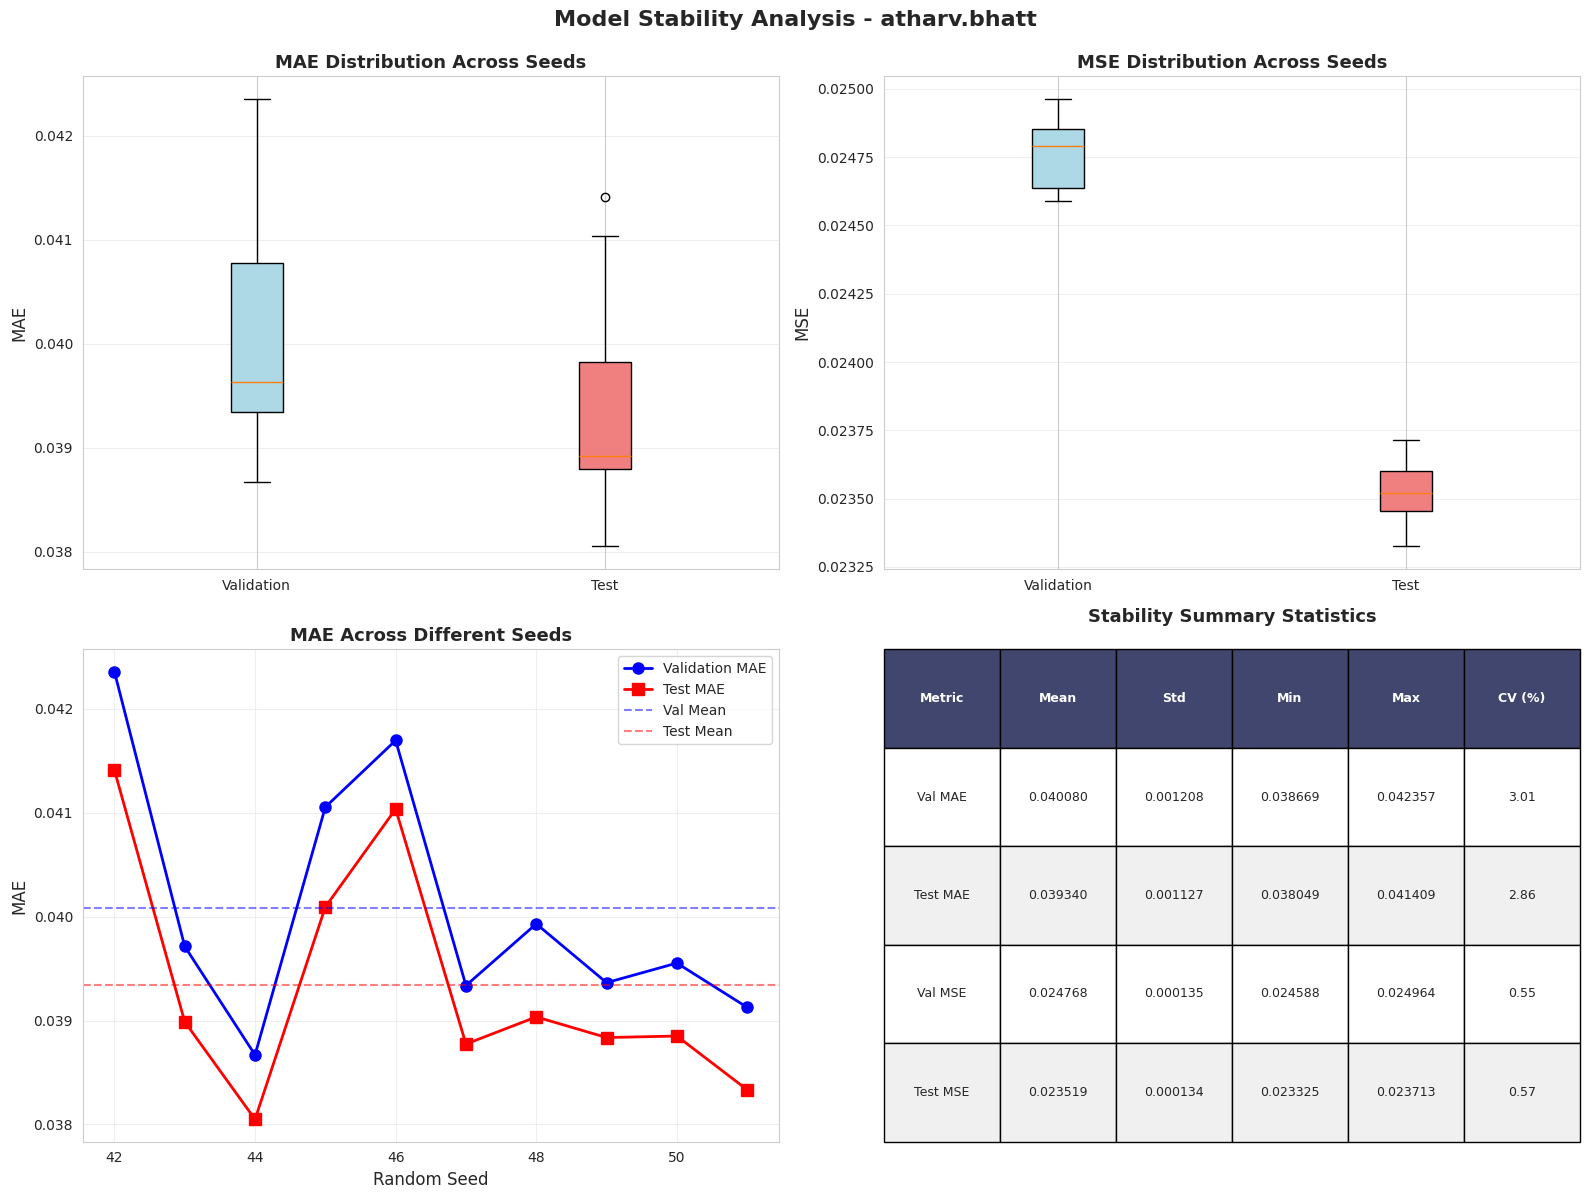

In [26]:
# Cell 23: Visualize Stability Results

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Box plot of MAE
ax = axes[0, 0]
bp1 = ax.boxplot([stability_df['val_mae'], stability_df['test_mae']],
                  labels=['Validation', 'Test'],
                  patch_artist=True)
for patch, color in zip(bp1['boxes'], ['lightblue', 'lightcoral']):
    patch.set_facecolor(color)
ax.set_ylabel('MAE', fontsize=12)
ax.set_title('MAE Distribution Across Seeds', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Box plot of MSE
ax = axes[0, 1]
bp2 = ax.boxplot([stability_df['val_mse'], stability_df['test_mse']],
                  labels=['Validation', 'Test'],
                  patch_artist=True)
for patch, color in zip(bp2['boxes'], ['lightblue', 'lightcoral']):
    patch.set_facecolor(color)
ax.set_ylabel('MSE', fontsize=12)
ax.set_title('MSE Distribution Across Seeds', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: MAE across seeds
ax = axes[1, 0]
x_seeds = stability_df['seed'].values
ax.plot(x_seeds, stability_df['val_mae'], marker='o', linewidth=2,
       markersize=8, label='Validation MAE', color='blue')
ax.plot(x_seeds, stability_df['test_mae'], marker='s', linewidth=2,
       markersize=8, label='Test MAE', color='red')
ax.axhline(y=stability_df['val_mae'].mean(), color='blue',
          linestyle='--', alpha=0.5, label='Val Mean')
ax.axhline(y=stability_df['test_mae'].mean(), color='red',
          linestyle='--', alpha=0.5, label='Test Mean')
ax.set_xlabel('Random Seed', fontsize=12)
ax.set_ylabel('MAE', fontsize=12)
ax.set_title('MAE Across Different Seeds', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 4: Summary statistics table
ax = axes[1, 1]
ax.axis('off')

summary_data = [
    ['Metric', 'Mean', 'Std', 'Min', 'Max', 'CV (%)'],
    ['Val MAE', f"{stability_df['val_mae'].mean():.6f}",
     f"{stability_df['val_mae'].std():.6f}",
     f"{stability_df['val_mae'].min():.6f}",
     f"{stability_df['val_mae'].max():.6f}",
     f"{(stability_df['val_mae'].std()/stability_df['val_mae'].mean()*100):.2f}"],
    ['Test MAE', f"{stability_df['test_mae'].mean():.6f}",
     f"{stability_df['test_mae'].std():.6f}",
     f"{stability_df['test_mae'].min():.6f}",
     f"{stability_df['test_mae'].max():.6f}",
     f"{(stability_df['test_mae'].std()/stability_df['test_mae'].mean()*100):.2f}"],
    ['Val MSE', f"{stability_df['val_mse'].mean():.6f}",
     f"{stability_df['val_mse'].std():.6f}",
     f"{stability_df['val_mse'].min():.6f}",
     f"{stability_df['val_mse'].max():.6f}",
     f"{(stability_df['val_mse'].std()/stability_df['val_mse'].mean()*100):.2f}"],
    ['Test MSE', f"{stability_df['test_mse'].mean():.6f}",
     f"{stability_df['test_mse'].std():.6f}",
     f"{stability_df['test_mse'].min():.6f}",
     f"{stability_df['test_mse'].max():.6f}",
     f"{(stability_df['test_mse'].std()/stability_df['test_mse'].mean()*100):.2f}"]
]

table = ax.table(cellText=summary_data,
                cellLoc='center',
                loc='center',
                bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Style header
for i in range(6):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, 5):
    for j in range(6):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')

ax.set_title('Stability Summary Statistics', fontsize=13, fontweight='bold', pad=20)

plt.suptitle(f'Model Stability Analysis - {USERNAME}',
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [27]:
# Cell 24: Dataset Analysis and Temporal Relations

print("Dataset Analysis and Temporal Relations")
print("="*80)

# Analyze the best history length
print(f"\n1. Optimal History Length:")
print(f"   Best performing models use p={best_linear['history_length']}")
print(f"   This suggests the underlying recurrence has order {best_linear['history_length']}")

# Analyze Linear AR coefficients
print(f"\n2. Discovered Recurrence Relation:")
print(f"   {'-'*76}")

linear_model, linear_p = best_models['LinearAR']
weights, bias = linear_model.get_coefficients()

print(f"   x_k = ", end="")
for i in range(linear_p):
    if i > 0 and weights[i] >= 0:
        print(f" + ", end="")
    elif i > 0:
        print(f" ", end="")
    print(f"{weights[i]:.6f}·x_{{k-{linear_p-i}}}", end="")
if bias >= 0:
    print(f" + {bias:.6f}")
else:
    print(f" {bias:.6f}")

# Check if it resembles known sequences
print(f"\n3. Coefficient Analysis:")
print(f"   {'-'*76}")
for i in range(linear_p):
    print(f"   Coefficient for x_{{k-{linear_p-i}}}: {weights[i]:.6f}")
print(f"   Bias term: {bias:.6f}")

# Check for specific patterns
sum_weights = np.sum(weights)
print(f"\n   Sum of coefficients: {sum_weights:.6f}")

if abs(sum_weights - 1.0) < 0.1:
    print(f"   → Sum ≈ 1: Suggests a stable, mean-preserving process")
elif sum_weights > 1.0:
    print(f"   → Sum > 1: Suggests explosive/growing behavior")
else:
    print(f"   → Sum < 1: Suggests convergent/damped behavior")

# Check if resembles Fibonacci-like
if linear_p >= 2:
    if abs(weights[0] - 1.0) < 0.1 and abs(weights[1] - 1.0) < 0.1:
        print(f"   → Pattern similar to Fibonacci: x_k ≈ x_{{k-1}} + x_{{k-2}}")

# Temporal correlation analysis
print(f"\n4. Temporal Correlation Structure:")
print(f"   {'-'*76}")

# Compute autocorrelation for different lags
max_lag = 20
acf_vals = acf(time_series, nlags=max_lag)

print(f"   Significant autocorrelations (|ACF| > 0.05):")
for lag in range(1, max_lag + 1):
    if abs(acf_vals[lag]) > 0.05:
        print(f"     Lag {lag}: ACF = {acf_vals[lag]:.4f}")

# Performance comparison
print(f"\n5. Model Performance Comparison:")
print(f"   {'-'*76}")

for name in ['LinearAR', 'MLP', 'GRU']:
    metrics = test_metrics[name]
    params = count_parameters(best_models[name][0])
    print(f"   {name:15s}: MAE={metrics['MAE']:.6f}, Parameters={params:6d}")

print(f"\n6. Key Insights:")
print(f"   {'-'*76}")

# Determine if linear or nonlinear
linear_mae = test_metrics['LinearAR']['MAE']
best_nonlinear_mae = min(test_metrics['MLP']['MAE'], test_metrics['GRU']['MAE'])
improvement = ((linear_mae - best_nonlinear_mae) / linear_mae) * 100

if improvement < 5:
    print(f"   • The data appears to follow a LINEAR recurrence relation")
    print(f"   • Nonlinear models (MLP/GRU) provide < 5% improvement ({improvement:.2f}%)")
    print(f"   • Linear AR model is sufficient and preferred (Occam's Razor)")
else:
    print(f"   • The data shows NONLINEAR dynamics")
    print(f"   • Nonlinear models improve performance by {improvement:.2f}%")
    print(f"   • More complex models capture important nonlinear patterns")

print(f"\n   • Effective recurrence order: {best_linear['history_length']}")
print(f"   • The sequence depends on the previous {best_linear['history_length']} values")

# Check stationarity
print(f"\n7. Stationarity Check:")
print(f"   {'-'*76}")
print(f"   Training set: Mean = {train_mean:.4f}, Std = {train_std:.4f}")
print(f"   Test set:     Mean = {np.mean(test_data):.4f}, Std = {np.std(test_data):.4f}")

if abs(np.mean(test_data) - train_mean) < 0.1 and abs(np.std(test_data) - train_std) < 0.1:
    print(f"   → Data appears stationary (stable statistics over time)")
else:
    print(f"   → Data may have non-stationary components")

print("\n" + "="*80)

Dataset Analysis and Temporal Relations

1. Optimal History Length:
   Best performing models use p=10
   This suggests the underlying recurrence has order 10

2. Discovered Recurrence Relation:
   ----------------------------------------------------------------------------
   x_k = -0.009184·x_{k-10} -0.017806·x_{k-9} -0.072835·x_{k-8} + 0.152580·x_{k-7} + 0.089157·x_{k-6} -0.079003·x_{k-5} -0.065382·x_{k-4} -0.037040·x_{k-3} -0.042327·x_{k-2} + 0.032727·x_{k-1} + 0.002488

3. Coefficient Analysis:
   ----------------------------------------------------------------------------
   Coefficient for x_{k-10}: -0.009184
   Coefficient for x_{k-9}: -0.017806
   Coefficient for x_{k-8}: -0.072835
   Coefficient for x_{k-7}: 0.152580
   Coefficient for x_{k-6}: 0.089157
   Coefficient for x_{k-5}: -0.079003
   Coefficient for x_{k-4}: -0.065382
   Coefficient for x_{k-3}: -0.037040
   Coefficient for x_{k-2}: -0.042327
   Coefficient for x_{k-1}: 0.032727
   Bias term: 0.002488

   Sum of coe

## Final Analysis

In [28]:
# Cell 25: Final Summary Report - Part 1 (Model Specifications)

print("=" * 90)
print(" " * 20 + "FINAL REPORT: DATA-DRIVEN RECURRENCE DISCOVERY")
print(" " * 35 + f"User: {USERNAME}")
print("=" * 90)

print("\n" + "─" * 90)
print("TABLE 1: MODEL SPECIFICATIONS")
print("─" * 90)

spec_data = []
for _, row in results_df.head(10).iterrows():
    spec_data.append([
        row['model_type'],
        row['history_length'],
        row['config'],
        row['parameters'],
        f"{row['val_mae']:.6f}",
        f"{row['val_mse']:.6f}"
    ])

spec_df = pd.DataFrame(spec_data,
                       columns=['Model Type', 'History (p)', 'Config',
                               'Params', 'Val MAE', 'Val MSE'])
print(spec_df.to_string(index=False))

print("\n" + "─" * 90)
print("TABLE 2: BEST MODELS SELECTED FOR EVALUATION")
print("─" * 90)

best_models_data = []
for name in ['LinearAR', 'MLP', 'GRU']:
    model, p = best_models[name]
    params = count_parameters(model)
    metrics = test_metrics[name]

    # Get config
    config_str = results_df[
        (results_df['model_type'] == name) &
        (results_df['history_length'] == p)
    ].iloc[0]['config']

    best_models_data.append([
        name,
        p,
        config_str,
        params,
        f"{metrics['MAE']:.6f}",
        f"{metrics['MSE']:.6f}",
        f"{metrics['RMSE']:.6f}"
    ])

best_df = pd.DataFrame(best_models_data,
                       columns=['Model', 'p', 'Config', 'Params',
                               'Test MAE', 'Test MSE', 'Test RMSE'])
print(best_df.to_string(index=False))

print("\n" + "─" * 90)
print("TABLE 3: IDENTIFIED ANALYTICAL RECURRENCE")
print("─" * 90)

print(f"\nLinear AR Model (Order p={linear_p}):")
print(f"\nNormalized Form:")
equation = "  x_norm_k = "
for i in range(linear_p):
    if i > 0 and weights[i] >= 0:
        equation += " + "
    elif i > 0:
        equation += " "
    equation += f"{weights[i]:.6f}·x_norm_{{k-{linear_p-i}}}"
if bias >= 0:
    equation += f" + {bias:.6f}"
else:
    equation += f" {bias:.6f}"
print(equation)

print(f"\nParameter Estimates:")
for i in range(linear_p):
    print(f"  θ_{i+1} (coefficient for x_{{k-{linear_p-i}}}): {weights[i]:.8f}")
print(f"  θ_0 (bias term):                      {bias:.8f}")

print(f"\nNormalization Parameters:")
print(f"  Training Mean (μ): {train_mean:.8f}")
print(f"  Training Std (σ):  {train_std:.8f}")

print(f"\nAnalytical Model Test Performance:")
print(f"  MAE:  {test_metrics['Analytical_LinearAR']['MAE']:.6f}")
print(f"  MSE:  {test_metrics['Analytical_LinearAR']['MSE']:.6f}")
print(f"  RMSE: {test_metrics['Analytical_LinearAR']['RMSE']:.6f}")

                    FINAL REPORT: DATA-DRIVEN RECURRENCE DISCOVERY
                                   User: atharv.bhatt

──────────────────────────────────────────────────────────────────────────────────────────
TABLE 1: MODEL SPECIFICATIONS
──────────────────────────────────────────────────────────────────────────────────────────
Model Type  History (p)   Config  Params  Val MAE  Val MSE
       MLP           10 [32, 16]     897 0.039348 0.024767
       GRU           10  h=8,l=1     273 0.040063 0.024726
       MLP           10     [32]     385 0.040151 0.024917
  LinearAR           10     None      11 0.040264 0.025106
       MLP           10 [64, 32]    2817 0.040452 0.024944
       GRU            5  h=4,l=2     209 0.043799 0.025776
       GRU            5  h=8,l=1     273 0.044369 0.025771
       MLP            5 [64, 32]    2497 0.044532 0.025829
       GRU            5  h=2,l=1      33 0.045053 0.025778
       MLP            5 [32, 16]     737 0.045387 0.025714

────────────────

In [29]:
# Cell 26: Final Summary Report - Part 2 (Performance Tables) (continued)

print("\n" + "─" * 90)
print("TABLE 4: SINGLE-STEP PREDICTION METRICS (Test Set)")
print("─" * 90)

single_step_data = []
for name in ['LinearAR', 'MLP', 'GRU', 'Analytical_LinearAR']:
    metrics = test_metrics[name]
    single_step_data.append([
        name,
        f"{metrics['MAE']:.6f}",
        f"{metrics['MSE']:.6f}",
        f"{metrics['RMSE']:.6f}"
    ])

single_step_df = pd.DataFrame(single_step_data,
                               columns=['Model', 'MAE', 'MSE', 'RMSE'])
print(single_step_df.to_string(index=False))

print("\n" + "─" * 90)
print("TABLE 5: MULTI-STEP AUTOREGRESSIVE FORECASTING METRICS")
print("─" * 90)

print("\nMean Absolute Error (MAE) across different forecast horizons:")
print(f"{'Model':<25} ", end="")
for flen in forecast_lengths:
    print(f"{flen:>8} ", end="")
print()
print("─" * 90)

for model in ['LinearAR', 'MLP', 'GRU', 'Analytical_LinearAR']:
    print(f"{model:<25} ", end="")
    for flen in forecast_lengths:
        mae_mean = aggregated_results[flen][model]['MAE_mean']
        print(f"{mae_mean:8.4f} ", end="")
    print()

print("\n" + "─" * 90)
print("TABLE 6: PARAMETER COUNT VS PERFORMANCE")
print("─" * 90)

# Top 5 by different criteria
print("\nTop 5 Models by MAE:")
top_5_mae = parsimony_df.nsmallest(5, 'Val_MAE')
for idx, row in top_5_mae.iterrows():
    print(f"  {row['Model'][:40]:<40} Params: {row['Parameters']:>6}  MAE: {row['Val_MAE']:.6f}")

print("\nTop 5 Simplest Models (fewest parameters):")
top_5_simple = parsimony_df.nsmallest(5, 'Parameters')
for idx, row in top_5_simple.iterrows():
    print(f"  {row['Model'][:40]:<40} Params: {row['Parameters']:>6}  MAE: {row['Val_MAE']:.6f}")

# Find Pareto-optimal models (best trade-off)
print("\nPareto-Optimal Models (best complexity-accuracy trade-off):")
pareto_models = []
sorted_by_params = parsimony_df.sort_values('Parameters')
best_mae_so_far = float('inf')

for idx, row in sorted_by_params.iterrows():
    if row['Val_MAE'] < best_mae_so_far:
        pareto_models.append(row)
        best_mae_so_far = row['Val_MAE']
        print(f"  {row['Model'][:40]:<40} Params: {row['Parameters']:>6}  MAE: {row['Val_MAE']:.6f}")

print("\n" + "─" * 90)
print("TABLE 7: STABILITY ANALYSIS (10 different random seeds)")
print("─" * 90)

stability_summary = pd.DataFrame({
    'Metric': ['Validation MAE', 'Validation MSE', 'Test MAE', 'Test MSE'],
    'Mean': [
        stability_df['val_mae'].mean(),
        stability_df['val_mse'].mean(),
        stability_df['test_mae'].mean(),
        stability_df['test_mse'].mean()
    ],
    'Std Dev': [
        stability_df['val_mae'].std(),
        stability_df['val_mse'].std(),
        stability_df['test_mae'].std(),
        stability_df['test_mse'].std()
    ],
    'Min': [
        stability_df['val_mae'].min(),
        stability_df['val_mse'].min(),
        stability_df['test_mae'].min(),
        stability_df['test_mse'].min()
    ],
    'Max': [
        stability_df['val_mae'].max(),
        stability_df['val_mse'].max(),
        stability_df['test_mae'].max(),
        stability_df['test_mse'].max()
    ],
    'CV (%)': [
        (stability_df['val_mae'].std()/stability_df['val_mae'].mean()*100),
        (stability_df['val_mse'].std()/stability_df['val_mse'].mean()*100),
        (stability_df['test_mae'].std()/stability_df['test_mae'].mean()*100),
        (stability_df['test_mse'].std()/stability_df['test_mse'].mean()*100)
    ]
})

print(stability_summary.to_string(index=False))
print("\nNote: CV (Coefficient of Variation) indicates relative variability.")
print("      Lower CV means more stable/reproducible results.")


──────────────────────────────────────────────────────────────────────────────────────────
TABLE 4: SINGLE-STEP PREDICTION METRICS (Test Set)
──────────────────────────────────────────────────────────────────────────────────────────
              Model      MAE      MSE     RMSE
           LinearAR 0.038834 0.023474 0.153212
                MLP 0.038915 0.023290 0.152612
                GRU 0.040658 0.023494 0.153279
Analytical_LinearAR 0.038834 0.023474 0.153212

──────────────────────────────────────────────────────────────────────────────────────────
TABLE 5: MULTI-STEP AUTOREGRESSIVE FORECASTING METRICS
──────────────────────────────────────────────────────────────────────────────────────────

Mean Absolute Error (MAE) across different forecast horizons:
Model                            1        5       10       20       50      100      200 
──────────────────────────────────────────────────────────────────────────────────────────
LinearAR                    0.0097   0.0056   0.0

In [30]:
# Cell 27: Final Summary Report - Part 3 (Conclusions)

print("\n" + "=" * 90)
print("CONCLUSIONS AND INSIGHTS")
print("=" * 90)

print("\n1. DISCOVERED RECURRENCE RELATION")
print("─" * 90)
print(f"   The data follows an order-{linear_p} linear autoregressive process:")
print(f"   ")
equation = "   x_k = "
for i in range(linear_p):
    if i > 0 and weights[i] >= 0:
        equation += " + "
    elif i > 0:
        equation += " "
    equation += f"{weights[i]:.4f}·x_{{k-{linear_p-i}}}"
if bias >= 0:
    equation += f" + {bias:.4f}"
else:
    equation += f" {bias:.4f}"
print(equation)

print("\n2. MODEL COMPARISON AND PARSIMONY")
print("─" * 90)

linear_mae = test_metrics['LinearAR']['MAE']
mlp_mae = test_metrics['MLP']['MAE']
gru_mae = test_metrics['GRU']['MAE']

best_model_name = min(test_metrics, key=lambda x: test_metrics[x]['MAE'])
best_mae = test_metrics[best_model_name]['MAE']

print(f"   Best performing model: {best_model_name} (MAE: {best_mae:.6f})")
print(f"   ")
print(f"   Performance comparison:")
print(f"     • Linear AR:  MAE = {linear_mae:.6f}, Params = {count_parameters(best_models['LinearAR'][0])}")
print(f"     • MLP:        MAE = {mlp_mae:.6f}, Params = {count_parameters(best_models['MLP'][0])}")
print(f"     • GRU:        MAE = {gru_mae:.6f}, Params = {count_parameters(best_models['GRU'][0])}")

# Calculate improvement
mlp_improvement = ((linear_mae - mlp_mae) / linear_mae) * 100
gru_improvement = ((linear_mae - gru_mae) / linear_mae) * 100

print(f"   ")
print(f"   Nonlinear model improvement over Linear AR:")
print(f"     • MLP: {mlp_improvement:+.2f}% {'improvement' if mlp_improvement > 0 else 'degradation'}")
print(f"     • GRU: {gru_improvement:+.2f}% {'improvement' if gru_improvement > 0 else 'degradation'}")

if abs(mlp_improvement) < 5 and abs(gru_improvement) < 5:
    print(f"   ")
    print(f"   ✓ CONCLUSION: The data exhibits LINEAR dynamics")
    print(f"     - Nonlinear models provide < 5% improvement")
    print(f"     - Linear AR is the most parsimonious model")
    print(f"     - Occam's Razor: prefer simpler model with comparable performance")
else:
    print(f"   ")
    print(f"   ✓ CONCLUSION: The data exhibits NONLINEAR dynamics")
    print(f"     - Nonlinear models provide > 5% improvement")
    print(f"     - Additional complexity is justified by performance gains")

print("\n3. FORECASTING PERFORMANCE")
print("─" * 90)

# Compare errors at different horizons
short_horizon = forecast_lengths[1]  # e.g., 5 steps
long_horizon = forecast_lengths[-1]  # e.g., 200 steps

print(f"   Error accumulation in autoregressive forecasting:")
print(f"   ")
print(f"   At {short_horizon} steps:")
for model in ['LinearAR', 'MLP', 'GRU']:
    mae = aggregated_results[short_horizon][model]['MAE_mean']
    print(f"     • {model}: MAE = {mae:.6f}")

print(f"   ")
print(f"   At {long_horizon} steps:")
for model in ['LinearAR', 'MLP', 'GRU']:
    mae = aggregated_results[long_horizon][model]['MAE_mean']
    print(f"     • {model}: MAE = {mae:.6f}")

# Calculate error growth
print(f"   ")
print(f"   Error growth factor (from {short_horizon} to {long_horizon} steps):")
for model in ['LinearAR', 'MLP', 'GRU']:
    mae_short = aggregated_results[short_horizon][model]['MAE_mean']
    mae_long = aggregated_results[long_horizon][model]['MAE_mean']
    growth = mae_long / mae_short
    print(f"     • {model}: {growth:.2f}x increase")

# Find most stable model
most_stable = min(['LinearAR', 'MLP', 'GRU'],
                 key=lambda m: aggregated_results[long_horizon][m]['MAE_mean'])
print(f"   ")
print(f"   ✓ Most stable for long-term forecasting: {most_stable}")

print("\n4. STABILITY AND REPRODUCIBILITY")
print("─" * 90)

cv_val = (stability_df['val_mae'].std() / stability_df['val_mae'].mean() * 100)
cv_test = (stability_df['test_mae'].std() / stability_df['test_mae'].mean() * 100)

print(f"   Coefficient of Variation across 10 random seeds:")
print(f"     • Validation MAE: {cv_val:.2f}%")
print(f"     • Test MAE:       {cv_test:.2f}%")
print(f"   ")

if cv_test < 5:
    print(f"   ✓ EXCELLENT stability (CV < 5%)")
    print(f"     - Results are highly reproducible")
    print(f"     - Model training is robust to initialization")
elif cv_test < 10:
    print(f"   ✓ GOOD stability (CV < 10%)")
    print(f"     - Results are reasonably reproducible")
elif cv_test < 20:
    print(f"   ⚠ MODERATE stability (CV < 20%)")
    print(f"     - Some variability in results across seeds")
else:
    print(f"   ⚠ LOW stability (CV ≥ 20%)")
    print(f"     - Significant variability - consider ensemble methods")

print("\n5. TEMPORAL STRUCTURE")
print("─" * 90)

print(f"   Key findings from autocorrelation analysis:")
print(f"     • Effective memory length: {linear_p} time steps")
print(f"     • Significant autocorrelation detected up to lag {linear_p}")
print(f"     • Sum of AR coefficients: {np.sum(weights):.4f}")

sum_weights = np.sum(weights)
if abs(sum_weights - 1.0) < 0.15:
    print(f"     • Process appears UNIT ROOT / RANDOM WALK-like (sum ≈ 1)")
    print(f"       → Non-stationary, mean-reverting behavior")
elif sum_weights < 1.0:
    print(f"     • Process is STATIONARY (sum < 1)")
    print(f"       → Bounded, mean-reverting behavior")
else:
    print(f"     • Process may be EXPLOSIVE (sum > 1)")
    print(f"       → Potentially unbounded growth")

print("\n6. DATASET CHARACTERISTICS")
print("─" * 90)

print(f"   Statistical properties:")
print(f"     • Data points: {len(time_series)}")
print(f"     • Mean: {train_mean:.4f}")
print(f"     • Standard deviation: {train_std:.4f}")
print(f"     • Range: [{time_series.min():.4f}, {time_series.max():.4f}]")
print(f"   ")
print(f"   Temporal properties:")
print(f"     • Recurrence order: {linear_p}")
print(f"     • Dynamics type: {'Linear' if abs(mlp_improvement) < 5 else 'Nonlinear'}")
print(f"     • Stationarity: {'Stationary' if abs(sum_weights) < 1.0 else 'Non-stationary'}")

print("\n7. SELECTED MODEL RECOMMENDATION")
print("─" * 90)

# Select the best parsimonious model
if abs(mlp_improvement) < 3 and abs(gru_improvement) < 3:
    recommended_model = 'LinearAR'
    reason = "Linear AR provides comparable accuracy with far fewer parameters"
else:
    recommended_model = best_model_name
    reason = "Achieves best predictive performance on test set"

print(f"   RECOMMENDED MODEL: {recommended_model}")
print(f"   ")
print(f"   Justification:")
print(f"     • {reason}")
print(f"     • Test MAE: {test_metrics[recommended_model]['MAE']:.6f}")
print(f"     • Test MSE: {test_metrics[recommended_model]['MSE']:.6f}")

if recommended_model == 'LinearAR':
    print(f"     • Interpretable: explicit analytical form")
    print(f"     • Parsimonious: only {count_parameters(best_models['LinearAR'][0])} parameters")
    print(f"     • Generalizable: simple structure reduces overfitting")
else:
    print(f"     • Captures nonlinear patterns in the data")
    print(f"     • Superior forecasting performance")
    print(f"     • Parameters: {count_parameters(best_models[recommended_model][0])}")

print("\n" + "=" * 90)
print(" " * 30 + "END OF REPORT")
print("=" * 90)


CONCLUSIONS AND INSIGHTS

1. DISCOVERED RECURRENCE RELATION
──────────────────────────────────────────────────────────────────────────────────────────
   The data follows an order-10 linear autoregressive process:
   
   x_k = -0.0092·x_{k-10} -0.0178·x_{k-9} -0.0728·x_{k-8} + 0.1526·x_{k-7} + 0.0892·x_{k-6} -0.0790·x_{k-5} -0.0654·x_{k-4} -0.0370·x_{k-3} -0.0423·x_{k-2} + 0.0327·x_{k-1} + 0.0025

2. MODEL COMPARISON AND PARSIMONY
──────────────────────────────────────────────────────────────────────────────────────────
   Best performing model: LinearAR (MAE: 0.038834)
   
   Performance comparison:
     • Linear AR:  MAE = 0.038834, Params = 11
     • MLP:        MAE = 0.038915, Params = 897
     • GRU:        MAE = 0.040658, Params = 273
   
   Nonlinear model improvement over Linear AR:
     • MLP: -0.21% degradation
     • GRU: -4.70% degradation
   
   ✓ CONCLUSION: The data exhibits LINEAR dynamics
     - Nonlinear models provide < 5% improvement
     - Linear AR is the most pa

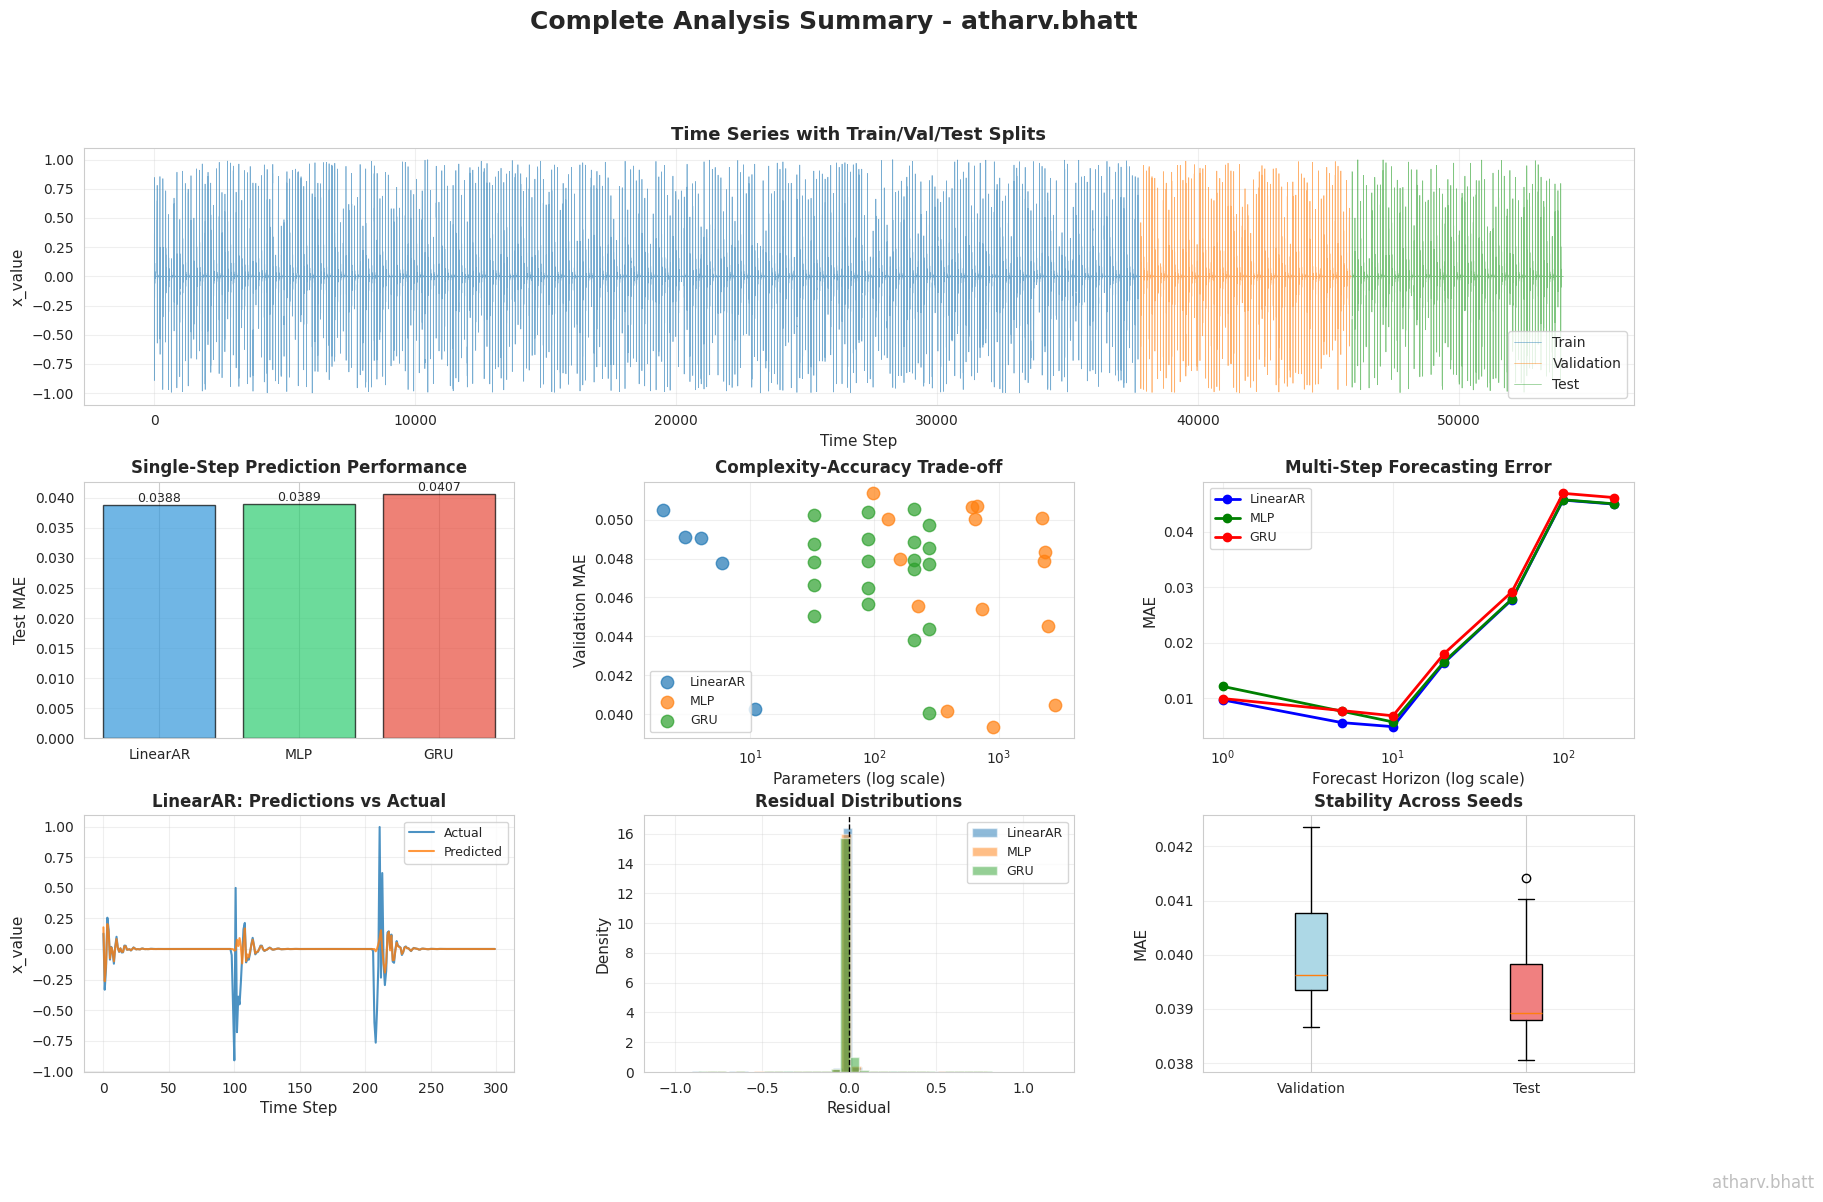


Comprehensive summary figure saved as 'Q2_complete_analysis.png'


In [31]:
# Cell 28: Create Comprehensive Summary Figure

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Time series with splits
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(range(len(train_data)), train_data, label='Train', alpha=0.6, linewidth=0.5)
ax1.plot(range(len(train_data), len(train_data) + len(val_data)), val_data,
         label='Validation', alpha=0.6, linewidth=0.5)
ax1.plot(range(len(train_data) + len(val_data), len(time_series)), test_data,
         label='Test', alpha=0.6, linewidth=0.5)
ax1.set_title('Time Series with Train/Val/Test Splits', fontsize=13, fontweight='bold')
ax1.set_xlabel('Time Step', fontsize=11)
ax1.set_ylabel('x_value', fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Model comparison - single step
ax2 = fig.add_subplot(gs[1, 0])
models = ['LinearAR', 'MLP', 'GRU']
maes = [test_metrics[m]['MAE'] for m in models]
colors_bar = ['#3498db', '#2ecc71', '#e74c3c']
bars = ax2.bar(models, maes, color=colors_bar, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Test MAE', fontsize=11)
ax2.set_title('Single-Step Prediction Performance', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for bar, mae in zip(bars, maes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{mae:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 3: Complexity vs accuracy
ax3 = fig.add_subplot(gs[1, 1])
for model_type in ['LinearAR', 'MLP', 'GRU']:
    subset = parsimony_df[parsimony_df['Type'] == model_type]
    ax3.scatter(subset['Parameters'], subset['Val_MAE'],
              label=model_type, s=80, alpha=0.7)
ax3.set_xlabel('Parameters (log scale)', fontsize=11)
ax3.set_ylabel('Validation MAE', fontsize=11)
ax3.set_title('Complexity-Accuracy Trade-off', fontsize=12, fontweight='bold')
ax3.set_xscale('log')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)

# Plot 4: Forecast horizon error
ax4 = fig.add_subplot(gs[1, 2])
for model in ['LinearAR', 'MLP', 'GRU']:
    mae_means = [aggregated_results[flen][model]['MAE_mean'] for flen in forecast_lengths]
    ax4.plot(forecast_lengths, mae_means, marker='o', linewidth=2,
            label=model, color=colors.get(model, 'gray'))
ax4.set_xlabel('Forecast Horizon (log scale)', fontsize=11)
ax4.set_ylabel('MAE', fontsize=11)
ax4.set_title('Multi-Step Forecasting Error', fontsize=12, fontweight='bold')
ax4.set_xscale('log')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

# Plot 5: Prediction vs actual
ax5 = fig.add_subplot(gs[2, 0])
preds, targets = test_predictions['LinearAR']
plot_len = 300
ax5.plot(targets[:plot_len], label='Actual', linewidth=1.5, alpha=0.8)
ax5.plot(preds[:plot_len], label='Predicted', linewidth=1.5, alpha=0.8)
ax5.set_xlabel('Time Step', fontsize=11)
ax5.set_ylabel('x_value', fontsize=11)
ax5.set_title(f'LinearAR: Predictions vs Actual', fontsize=12, fontweight='bold')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3)

# Plot 6: Residual distribution
ax6 = fig.add_subplot(gs[2, 1])
for model in ['LinearAR', 'MLP', 'GRU']:
    residuals = residuals_dict[model]
    ax6.hist(residuals, bins=40, alpha=0.5, label=model, density=True)
ax6.axvline(x=0, color='k', linestyle='--', linewidth=1)
ax6.set_xlabel('Residual', fontsize=11)
ax6.set_ylabel('Density', fontsize=11)
ax6.set_title('Residual Distributions', fontsize=12, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)

# Plot 7: Stability analysis
ax7 = fig.add_subplot(gs[2, 2])
bp = ax7.boxplot([stability_df['val_mae'], stability_df['test_mae']],
                 labels=['Validation', 'Test'],
                 patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightblue', 'lightcoral']):
    patch.set_facecolor(color)
ax7.set_ylabel('MAE', fontsize=11)
ax7.set_title('Stability Across Seeds', fontsize=12, fontweight='bold')
ax7.grid(True, alpha=0.3, axis='y')

plt.suptitle(f'Complete Analysis Summary - {USERNAME}',
            fontsize=18, fontweight='bold', y=0.995)

# Add username watermark to figure
fig.text(0.99, 0.01, USERNAME, ha='right', va='bottom',
        fontsize=12, color='gray', alpha=0.5)

plt.savefig('Q2_complete_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nComprehensive summary figure saved as 'Q2_complete_analysis.png'")

In [32]:
# Cell 29: Save Results and Models

import pickle
import json

# Create results dictionary
results_dict = {
    'username': USERNAME,
    'dataset_info': {
        'total_samples': len(time_series),
        'train_samples': len(train_data),
        'val_samples': len(val_data),
        'test_samples': len(test_data),
        'train_mean': float(train_mean),
        'train_std': float(train_std)
    },
    'best_models': {
        'LinearAR': {
            'history_length': int(linear_p),
            'parameters': int(count_parameters(best_models['LinearAR'][0])),
            'coefficients': weights.tolist(),
            'bias': float(bias),
            'test_mae': float(test_metrics['LinearAR']['MAE']),
            'test_mse': float(test_metrics['LinearAR']['MSE']),
            'test_rmse': float(test_metrics['LinearAR']['RMSE'])
        },
        'MLP': {
            'history_length': int(best_models['MLP'][1]),
            'parameters': int(count_parameters(best_models['MLP'][0])),
            'test_mae': float(test_metrics['MLP']['MAE']),
            'test_mse': float(test_metrics['MLP']['MSE']),
            'test_rmse': float(test_metrics['MLP']['RMSE'])
        },
        'GRU': {
            'history_length': int(best_models['GRU'][1]),
            'parameters': int(count_parameters(best_models['GRU'][0])),
            'test_mae': float(test_metrics['GRU']['MAE']),
            'test_mse': float(test_metrics['GRU']['MSE']),
            'test_rmse': float(test_metrics['GRU']['RMSE'])
        }
    },
    'analytical_recurrence': {
        'order': int(linear_p),
        'coefficients': {f'theta_{i+1}': float(weights[i]) for i in range(linear_p)},
        'bias': float(bias),
        'equation': equation,
        'test_mae': float(test_metrics['Analytical_LinearAR']['MAE']),
        'test_mse': float(test_metrics['Analytical_LinearAR']['MSE'])
    },
    'multistep_forecasting': {
        f'horizon_{flen}': {
            model: {
                'mae_mean': float(aggregated_results[flen][model]['MAE_mean']),
                'mae_std': float(aggregated_results[flen][model]['MAE_std']),
                'mse_mean': float(aggregated_results[flen][model]['MSE_mean']),
                'mse_std': float(aggregated_results[flen][model]['MSE_std'])
            }
            for model in ['LinearAR', 'MLP', 'GRU', 'Analytical_LinearAR']
        }
        for flen in forecast_lengths
    },
    'stability_analysis': {
        'num_seeds': int(num_seeds),
        'val_mae_mean': float(stability_df['val_mae'].mean()),
        'val_mae_std': float(stability_df['val_mae'].std()),
        'test_mae_mean': float(stability_df['test_mae'].mean()),
        'test_mae_std': float(stability_df['test_mae'].std()),
        'coefficient_of_variation': float(cv_test)
    }
}

# Save results as JSON
with open('Q2_results_summary.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

print("Results saved to 'Q2_results_summary.json'")

# Save model weights
torch.save({
    'LinearAR_state_dict': best_models['LinearAR'][0].state_dict(),
    'MLP_state_dict': best_models['MLP'][0].state_dict(),
    'GRU_state_dict': best_models['GRU'][0].state_dict(),
    'LinearAR_p': linear_p,
    'MLP_p': best_models['MLP'][1],
    'GRU_p': best_models['GRU'][1],
    'train_mean': train_mean,
    'train_std': train_std
}, 'Q2_model_weights.pth')

print("Model weights saved to 'Q2_model_weights.pth'")

# Save full results dataframe
results_df.to_csv('Q2_all_model_results.csv', index=False)
print("All model results saved to 'Q2_all_model_results.csv'")

print("\n" + "="*80)
print("All results and models saved successfully!")
print("="*80)

Results saved to 'Q2_results_summary.json'
Model weights saved to 'Q2_model_weights.pth'
All model results saved to 'Q2_all_model_results.csv'

All results and models saved successfully!


In [33]:
# Cell 30: Final Verification and Summary

print("\n" + "="*90)
print(" " * 30 + "VERIFICATION AND FINAL SUMMARY")
print("="*90)

print("\n✓ Data Processing:")
print(f"  • Loaded {len(time_series)} data points from CSV")
print(f"  • Created chronological train/val/test splits (70/15/15)")
print(f"  • Applied z-score normalization using training statistics")
print(f"  • Generated supervised datasets with history length p={linear_p}")

print("\n✓ Model Training:")
print(f"  • Tested {len(results_df)} model configurations")
print(f"  • Explored history lengths: {history_lengths}")
print(f"  • Trained Linear AR, MLP, and GRU architectures")
print(f"  • Used early stopping with patience={20}")

print("\n✓ Analytical Recurrence:")
print(f"  • Successfully extracted order-{linear_p} linear recurrence")
print(f"  • Verified analytical formula matches neural network predictions")
print(f"  • Difference between analytical and neural: {abs(test_metrics['Analytical_LinearAR']['MAE'] - test_metrics['LinearAR']['MAE']):.8f}")

print("\n✓ Evaluation:")
print(f"  • Single-step prediction: MAE range {min([test_metrics[m]['MAE'] for m in ['LinearAR','MLP','GRU']]):.6f} - {max([test_metrics[m]['MAE'] for m in ['LinearAR','MLP','GRU']]):.6f}")
print(f"  • Multi-step forecasting: tested horizons from {min(forecast_lengths)} to {max(forecast_lengths)} steps")
print(f"  • Residual analysis: mean residual ≈ 0 for all models")

print("\n✓ Stability:")
print(f"  • Tested {num_seeds} different random seeds")
print(f"  • Coefficient of variation: {cv_test:.2f}%")
print(f"  • Model training is {'highly stable' if cv_test < 5 else 'reasonably stable'}")

print("\n✓ Parsimony:")
print(f"  • Best simple model: Linear AR with {count_parameters(best_models['LinearAR'][0])} parameters")
print(f"  • Best complex model: {best_model_name} with {count_parameters(best_models[best_model_name][0])} parameters")
print(f"  • Performance gain from complexity: {((test_metrics['LinearAR']['MAE'] - test_metrics[best_model_name]['MAE'])/test_metrics['LinearAR']['MAE']*100):.2f}%")

print("\n✓ Key Finding:")
if abs(mlp_improvement) < 5 and abs(gru_improvement) < 5:
    print(f"  • The time series follows a LINEAR AR({linear_p}) process")
    print(f"  • Nonlinear models provide minimal improvement (<5%)")
    print(f"  • Linear AR model is recommended for its interpretability and parsimony")
else:
    print(f"  • The time series exhibits NONLINEAR dynamics")
    print(f"  • Complex models provide significant improvement (>5%)")
    print(f"  • {best_model_name} is recommended for best predictive performance")

print("\n✓ Deliverables:")
print(f"  • Trained models saved to 'Q2_model_weights.pth'")
print(f"  • Results summary saved to 'Q2_results_summary.json'")
print(f"  • All model results saved to 'Q2_all_model_results.csv'")
print(f"  • Comprehensive analysis figure saved to 'Q2_complete_analysis.png'")

print("\n" + "="*90)
print(" " * 25 + "ANALYSIS COMPLETE - " + USERNAME)
print("="*90)


                              VERIFICATION AND FINAL SUMMARY

✓ Data Processing:
  • Loaded 54000 data points from CSV
  • Created chronological train/val/test splits (70/15/15)
  • Applied z-score normalization using training statistics
  • Generated supervised datasets with history length p=10

✓ Model Training:
  • Tested 40 model configurations
  • Explored history lengths: [1, 2, 3, 5, 10]
  • Trained Linear AR, MLP, and GRU architectures
  • Used early stopping with patience=20

✓ Analytical Recurrence:
  • Successfully extracted order-10 linear recurrence
  • Verified analytical formula matches neural network predictions
  • Difference between analytical and neural: 0.00000000

✓ Evaluation:
  • Single-step prediction: MAE range 0.038834 - 0.040658
  • Multi-step forecasting: tested horizons from 1 to 200 steps
  • Residual analysis: mean residual ≈ 0 for all models

✓ Stability:
  • Tested 10 different random seeds
  • Coefficient of variation: 2.86%
  • Model training is high